# 0- Imports et fonctions

## 1- Imports des packages

In [ ]:
!python -m spacy download fr_core_news_md  # Download the French model

In [ ]:
!pip install coreferee  # Installer Coreferee
!python -m coreferee install fr  # Installer le modèle français

In [ ]:
import pandas as pd
import spacy
from tqdm import tqdm
import json
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
#import coreferee_model_fr

## 2- Données

In [ ]:
data = pd.read_csv("titres_ed_lemonde.csv", encoding = "utf-8", sep = ";",
                   on_bad_lines='skip')

## 3- Fonctions

In [ ]:
# Fonction pour formater les résultats
def format_results(text, ner_results):
    entities = [
        {
            "id": i,
            "start_offset": entity['start'],
            "end_offset": entity['end'],
            "label": entity['entity_group'],
            "text": entity['word']
        }
        for i, entity in enumerate(ner_results)
    ]
    # Placeholder for relations if needed
    relations = []  # Ajouter votre logique pour peupler les relations si nécessaire
    return {
        "text": text,
        "entities": entities,
        "relations": relations
    }


def extract_entity_texts(entities):
    """
    Prend une liste d'entités avec leurs offsets et renvoie le texte correspondant.

    Args:
        text (str): Le texte original.
        entities (list): Une liste de dictionnaires représentant les entités. Chaque dictionnaire
                         doit contenir les clés 'start' et 'end', qui sont les offsets.

    Returns:
        list: Une liste de tuples avec le texte de l'entité et ses offsets.
    """
    extracted_entities = []
    for entity in entities['entities']:
        start = entity['start_offset']
        end = entity['end_offset']
        entity_text = entities['text'][start:end]  # Extraction du texte de l'entité
        extracted_entities.append((entity_text, start, end))

    return extracted_entities


In [ ]:

def extract_entities(text):
    """Créer une liste vide results pour stocker les résultats à chaque utilisation"""
    max_length = 512
    stride = 25  # Chevauchement pour la troncature
    segments = []

    # Tokenization avec retour des segments
    inputs = tokenizer(
        text,
        return_tensors='pt',
        max_length=max_length,
        truncation=True,
        padding='max_length',
        stride=stride,
        return_overflowing_tokens=True
    )

    # Récupération des segments
    for i in range(len(inputs['input_ids'])):
        segment_ids = inputs['input_ids'][i]
        segment_text = tokenizer.decode(segment_ids, skip_special_tokens=True)

        # Appliquer le modèle NER au segment
        segment_results = nlp_ner(segment_text)

        formatted_results = format_results(segment_text, segment_results)
        results.append(formatted_results)



# I- Traitement des données pour l'annotation

In [ ]:
#Modèle NER Huggingface
tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/camembert-ner")
model = AutoModelForTokenClassification.from_pretrained("Jean-Baptiste/camembert-ner")
nlp_ner = pipeline('ner', model=model, tokenizer=tokenizer, aggregation_strategy="simple")
#nlp_spacy = spacy.load('fr_core_news_md')
#nlp_spacy.add_pipe('coreferee')

Test

In [ ]:
df = data.sample(250)

results = []

# Appliquer la fonction à chaque texte dans le DataFrame
tqdm.pandas(desc="Processing texts")
df['Full_Text_clean'].progress_apply(extract_entities)
#df['coref'] = df['Full_Text_clean'].progress_apply(lambda x: nlp_spacy(x))


# Enregistrer dans un fichier JSONL
with open('ner_results_for_doccano.jsonl', 'w', encoding='utf-8') as f:
    for result in results:
        json.dump(result, f, ensure_ascii=False)
        f.write('\n')

In [ ]:
dfto_csv("pour_chatgpt.csv")

In [ ]:
# prompt: transformer la colonne Full_Text_clean de df en fichier json

import json

# Convertir la colonne en liste
text_list = df['Full_Text_clean'].tolist()

# Enregistrer dans un fichier JSON
with open('text_data.json', 'w', encoding='utf-8') as f:
    json.dump(text_list, f, ensure_ascii=False)


In [ ]:
i = 0
j = 0
while i < 300 :
  name = f"output_{j}"
  globals()[name]= text_list[i:i+50]
  i += 50
  j += 1

In [ ]:
print(text_list[0])

"Tribune.Eric Zemmour n’est pas un produit de « politico-réalité » ni un amateur en politique que l’on pourrait sous-estimer. C’est un idéologue révolutionnaire, qui n’emprunte pas seulement aux années 1930 les thématiques religieuses, mais aussi les stratégies de conquête du pouvoir. Les Français en ont assez. Ils ont soif d’un récit national et d’autorité. Ils veulent à nouveau pouvoir se rassembler. Par la face noire, Eric Zemmour y répond, s’engouffrant dans l’espace laissé ouvert par une classe politique qui ne croit plus à la force des idées. S’inspirant d’idéologies qu’il connaît bien, il offre une réponse unique à tous les problèmes : l’immigré, le musulman. Comme hier avec le juif, tout devient simple : il faut éliminer celui qui nous submergerait et nous pervertirait. La stratégie politique est millimétrée. Aucune limite n’est posée à sa réalisation. Eric Zemmour aime et parle d’histoire et fait l’effort de la partager avec le plus grand nombre. Il contraste avec le mépris de

In [ ]:
# prompt: écrire une boucle qui enregistre en json output_0 à output°5

for i in range(6):
  filename = f"output_{i}.json"
  with open(filename, 'w', encoding='utf-8') as f:
    json.dump(globals()[f"output_{i}"], f, ensure_ascii=False)


In [ ]:
# prompt: enregistrer output_data0 à 5 en format txt

for i in range(6):
  filename = f"output_{i}.txt"
  with open(filename, 'w', encoding='utf-8') as f:
    for item in globals()[f"output_{i}"]:
      f.write(item + '\n')


# II- Fine-tuning du modèle

## 0- Imports et fonctions

In [ ]:
!pip install datasets
#!pip install seqeval

In [ ]:
from transformers import Trainer, TrainingArguments, AutoTokenizer, AutoModelForTokenClassification, pipeline, ProgressCallback
from transformers import CamembertTokenizerFast, CamembertForTokenClassification
import transformers
from transformers import DataCollatorForTokenClassification
from torch.utils.data import Dataset, random_split

In [ ]:
import datasets
from datasets import load_dataset, load_metric,  load_from_disk
import pandas as pd
import torch
import numpy as np
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
from tqdm import tqdm
import json
from huggingface_hub import HfApi, Repository, notebook_login
import re
import spacy

In [ ]:
# Charger le dataset JSONL
def load_jsonl_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data

# Exemple de chargement de ton fichier JSONL
data = load_jsonl_data('/content/anno_speech.jsonl')

# Transformer le dataset pour Hugging Face
dataset = datasets.Dataset.from_dict({
    "text": [item["text"] for item in data],
    "entities": [item["entities"] for item in data],
    "relations": [item["relations"] for item in data]
})


In [ ]:
print(dataset[0])

Dictionnaire de mapping pour les labels :

In [ ]:
def filter_entities(example):
  filtered_entities = []
  for entity in example['entities']:
    if entity['label'] in ['Orateur', 'Direct', 'indirect']:
      filtered_entities.append(entity)
  example['entities'] = filtered_entities
  return example

In [ ]:
dataset = list(map(filter_entities, dataset))

## 1- Préparation des données

### i. Découpage

In [ ]:
import spacy
from copy import deepcopy

In [ ]:
!python -m spacy download fr_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 13.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
test = dataset[0]

In [ ]:
print(test['entities'])

[{'end_offset': 196, 'id': 33732, 'label': 'Direct', 'start_offset': 171}, {'end_offset': 204, 'id': 33733, 'label': 'Orateur', 'start_offset': 202}, {'end_offset': 377, 'id': 33734, 'label': 'Direct', 'start_offset': 306}, {'end_offset': 385, 'id': 33735, 'label': 'Orateur', 'start_offset': 383}, {'end_offset': 799, 'id': 33736, 'label': 'Direct', 'start_offset': 740}, {'end_offset': 878, 'id': 33737, 'label': 'indirect', 'start_offset': 818}, {'end_offset': 807, 'id': 33738, 'label': 'Orateur', 'start_offset': 805}, {'end_offset': 1012, 'id': 33739, 'label': 'Direct', 'start_offset': 878}, {'end_offset': 1390, 'id': 33740, 'label': 'Direct', 'start_offset': 1169}, {'end_offset': 1521, 'id': 33741, 'label': 'Direct', 'start_offset': 1464}, {'end_offset': 1127, 'id': 33742, 'label': 'Orateur', 'start_offset': 1108}, {'end_offset': 1529, 'id': 33745, 'label': 'Orateur', 'start_offset': 1527}, {'end_offset': 1625, 'id': 33746, 'label': 'Direct', 'start_offset': 1582}, {'end_offset': 1787

In [ ]:
sentences = nlp(test).sents

In [ ]:
# Fonction pour découper le texte en phrases
nlp = spacy.load("fr_core_news_md")

In [ ]:
def make_sentences(text):
    # Accéder au texte à partir du dictionnaire
    text = text['text']

    # Traiter le texte avec le modèle spaCy
    doc = nlp(text)

    # Extraire les phrases détectées par spaCy
    sentences = [sent.text.strip() for sent in doc.sents]

    # Post-traitement pour fusionner les phrases contenant uniquement des guillemets
    combined_sentences = []
    buffer = ""

    i = 0
    while i < len(sentences):
        sentence = sentences[i].strip()

        # Si la phrase ne contient qu'une guillemet ouvrante
        if sentence == '«':
            # On fusionne avec la phrase suivante
            buffer = sentence + " " + sentences[i + 1].strip()
            combined_sentences.append(buffer)
            i += 2  # Sauter la phrase suivante car elle est fusionnée
        # Si la phrase ne contient qu'une guillemet fermante
        elif sentence == '»':
            # On fusionne avec la phrase précédente
            combined_sentences[-1] += " " + sentence
            i += 1  # Passer à la phrase suivante
        else:
            # Phrase normale
            combined_sentences.append(sentence)
            i += 1

    return combined_sentences

In [ ]:
a = make_sentences(test)

In [ ]:
def sentence_offsets(list_phrase):
    offsets = np.zeros(len(list_phrase), dtype=int)  # Initialiser les offsets à 0
    current_offset = 0  # Commencer à la position 0

    for i, phrase in enumerate(list_phrase):
        offsets[i] = current_offset  # Stocker l'offset de début de chaque phrase
        current_offset += len(phrase)  # Ajouter la longueur de la phrase à l'offset courant

    return offsets


In [ ]:
sentence_offsets(a)

array([   0,  171,  306,  434,  696,  738,  876, 1008, 1167, 1386, 1460,
       1577, 1620, 1686, 1884, 1987])

In [ ]:
def group_by_entities(text, sentences):
    grouped_sentences = sentences[:]  # Copie des phrases initiales
    iteration = 0

    while True:  # Boucle jusqu'à ce que les phrases ne changent plus
        new_grouped_sentences = entities(text, grouped_sentences)

        # Si aucune modification n'a été faite, on sort de la boucle
        if new_grouped_sentences == grouped_sentences:
            break

        grouped_sentences = new_grouped_sentences  # Mettre à jour les phrases groupées
        iteration += 1
        print(f"Iteration {iteration}")

    return grouped_sentences

def entities(text, grouped_sentences):
    """
    Cette fonction vérifie les entités et regroupe les phrases si elles sont couvertes
    par une même entité, tout en affichant le texte de l'entité si elle chevauche deux phrases.
    """
    entities = text['entities']
    text_content = text['text']
    offsets = sentence_offsets(grouped_sentences)
    new_grouped_sentences = []
    i = 0
    flag = None

    while i < len(grouped_sentences):
        sentence = grouped_sentences[i]
        sentence_start = offsets[i]
        sentence_end = sentence_start + len(sentence)
        if not flag : #si la phrase n'a pas déjà été groupée avec la précédente

              # Vérifier si l'entité doit provoquer un regroupement
              for entity in entities:
                  if sentence_start <= entity['start_offset'] <= sentence_end:
                      # Si l'entité chevauche la phrase suivante
                      if entity['end_offset'] > sentence_end:
                          # Imprimer le texte de l'entité récupérée depuis le texte original
                          entity_text = text_content[entity['start_offset']:entity['end_offset']]
                          print(f"Entité chevauchante trouvée: {entity_text}")

                          # Regrouper la phrase actuelle avec la suivante
                          if i + 1 < len(grouped_sentences):  # Vérifier qu'il y a une phrase suivante
                              next_sentence = grouped_sentences[i + 1]
                              next_sentence_start = offsets[i + 1]
                              group = sentence + " " + next_sentence
                              new_grouped_sentences.append((group, sentence_start))  # Fusionner avec le même offset de départ
                              flag = True
                              i += 1  # Sauter la phrase suivante, car elle est déjà fusionnée
                          break

              # Si aucun regroupement n'a été effectué, ajouter la phrase normale
              if not flag:
                  new_grouped_sentences.append((sentence, sentence_start))
        else :
              flag = None #Si on a skip la phrase, on réinitialise le flag
        i += 1  # Passer à la phrase suivante

    return new_grouped_sentences

In [ ]:
entities(test, a)

Entité chevauchante trouvée: « La gauche peut mourir »
Entité chevauchante trouvée: prévenant qu'il n'existe« pas d'alternative à gauche »du PS.
Entité chevauchante trouvée: « Si la tradition de la VeRépublique, de la majorité parlementaire automatique sous menace du 49-3 n'a jamais fait partie de notre culture, celle de la reparlementarisation à outrance des institutions n'est pas tenable. »
Entité chevauchante trouvée: « C'EST LE RETOUR À UN ROCARDISME DÉBRIDÉ »
Entité chevauchante trouvée: C'est le retour à un rocardisme débridé, c'est-à-dire la certitude d'être le seul à comprendre le réel. 


[('"Face aux risques de division de sa majorité avant le vote crucial sur le projet de loi de finances rectificative (PLFR), Manuel Valls n\'y est pas allé par quatre chemins. « La gauche peut mourir », a-t-il assené lors du Conseil national du Parti socialiste à la maison de la Chimie à Paris, samedi 14 juin.',
  0),
 ('Dans un discours à la tonalité sombre, tenu à huis clos devant le parlement du parti, le premier ministre a envoyé plusieurs avertissement aux députés « frondeurs », qui veulent infléchir la politique économique de Hollande, jugée trop en faveur des entreprises.',
  434),
 ("Manuel Valls a d'abord brandi le péril FN.", 696),
 ("« Notre pays peut se défaire et se donner à Marine Le Pen », a-t-il expliqué, prévenant qu'il n'existe« pas d'alternative à gauche »du PS. « Nous sentons bien que nous sommes arrivés au bout de quelque chose, au bout peut-être même d'un cycle historique pour notre parti.",
  738),
 ("Si la tradition de la VeRépublique, de la majorité parlementai

In [ ]:
def splitting_pipeline(text) :
  sentences = make_sentences(text)
  grouped_sentences = group_by_entities(text, sentences)
  return sentences, grouped_sentences

In [ ]:
splitting_pipeline(test)

In [ ]:
import spacy
from copy import deepcopy

# Charger le modèle de langue français
nlp = spacy.load("fr_core_news_md")


def entities_in_sentence(sentence_start, sentence_end, entities):
    """
    Retourne les entités dont les offsets sont dans la phrase.

    :param sentence_start: Début de la phrase dans le texte.
    :param sentence_end: Fin de la phrase dans le texte.
    :param entities: Liste des entités avec leurs offsets.
    :return: Les entités présentes dans la phrase.
    """
    sent_entities = []
    for entity in entities:
        if sentence_start <= entity['start_offset'] < sentence_end:
            sent_entities.append(entity)
    return sent_entities

def relations_in_sentence(sentence_start, sentence_end, relations, entities):
    """
    Retourne les relations dont au moins une des entités commence ou finit dans la phrase.

    :param sentence_start: Début de la phrase dans le texte.
    :param sentence_end: Fin de la phrase dans le texte.
    :param relations: Liste des relations avec les entités associées.
    :param entities: Liste des entités avec leurs offsets.
    :return: Les relations présentes dans la phrase.
    """
    sent_relations = []
    for relation in relations:
        # Obtenir les entités de la relation
        from_entity = next((e for e in entities if e['id'] == relation['from_id']), None)
        to_entity = next((e for e in entities if e['id'] == relation['to_id']), None)

        if from_entity and to_entity:
            if (sentence_start <= from_entity['start_offset'] < sentence_end or
                sentence_start <= to_entity['start_offset'] < sentence_end):
                sent_relations.append(relation)
    return sent_relations

def group_sentences(data):
    """
    Regroupe les phrases qui partagent des entités ou des relations.

    :param data: Un dictionnaire contenant 'text', 'entities', et 'relations'.
    :return: Une liste de groupes de phrases.
    """
    text = data['text']
    entities = data['entities']  # Liste des entités avec les offsets
    relations = data.get('relations', [])  # Les relations entre entités

    # Découper le texte en phrases avec spaCy
    sentences = split_text_into_sentences(text)

    # Obtenir les offsets des phrases
    doc = nlp(text)
    sentence_offsets = [(sent.start_char, sent.end_char) for sent in doc.sents]

    groups = []
    current_group = []
    current_group_entities = set()
    current_group_relations = set()

    i = 0
    while i < len(sentences):
        sent_text = sentences[i]
        sent_start, sent_end = sentence_offsets[i]

        # Trouver les entités dans la phrase actuelle
        sent_entities = entities_in_sentence(sent_start, sent_end, entities)
        sent_entity_ids = {entity['id'] for entity in sent_entities}

        # Trouver les relations dans la phrase actuelle
        sent_relations = relations_in_sentence(sent_start, sent_end, relations, entities)
        sent_relation_ids = {relation['id'] for relation in sent_relations}

        if not current_group:
            # Si le groupe est vide, ajouter la phrase, ses entités et ses relations
            current_group.append((sent_text, sent_start, sent_end, sent_entities, sent_relations))
            current_group_entities.update(sent_entity_ids)
            current_group_relations.update(sent_relation_ids)
        else:
            # Vérifier si cette phrase doit être regroupée avec le groupe actuel
            shared_entities = current_group_entities & sent_entity_ids
            shared_relations = current_group_relations & sent_relation_ids

            if shared_entities or shared_relations:  # Si des entités ou des relations se chevauchent
                current_group.append((sent_text, sent_start, sent_end, sent_entities, sent_relations))
                current_group_entities.update(sent_entity_ids)
                current_group_relations.update(sent_relation_ids)
            else:
                # Si pas de chevauchement d'entités ni de relations, créer un nouveau groupe
                groups.append(current_group)
                current_group = [(sent_text, sent_start, sent_end, sent_entities, sent_relations)]
                current_group_entities = sent_entity_ids
                current_group_relations = sent_relation_ids

        # Passer à la phrase suivante
        i += 1

    # Ajouter le dernier groupe
    if current_group:
        groups.append(current_group)

    return groups

In [ ]:
segments = group_sentences(dataset[0])

In [ ]:
for i in segments :
  print(i)

[('"Face aux risques de division de sa majorité avant le vote crucial sur le projet de loi de finances rectificative (PLFR), Manuel Valls n\'y est pas allé par quatre chemins.', 0, 171, [{'id': 26758, 'label': 'MISC', 'start_offset': 115, 'end_offset': 119}, {'id': 26759, 'label': 'PER', 'start_offset': 121, 'end_offset': 134}], [])]
[('«', 171, 172, [{'id': 33732, 'label': 'Direct', 'start_offset': 171, 'end_offset': 196}], [{'id': 137, 'from_id': 33733, 'to_id': 33732, 'type': 'Dit'}]), ('La gauche peut mourir », a-t-il assené lors du Conseil national du Parti socialiste à la maison de la Chimie à Paris, samedi 14 juin.', 173, 306, [{'id': 26760, 'label': 'ORG', 'start_offset': 219, 'end_offset': 236}, {'id': 26761, 'label': 'ORG', 'start_offset': 239, 'end_offset': 256}, {'id': 26762, 'label': 'LOC', 'start_offset': 261, 'end_offset': 281}, {'id': 26763, 'label': 'LOC', 'start_offset': 283, 'end_offset': 289}, {'id': 33733, 'label': 'Orateur', 'start_offset': 202, 'end_offset': 204}

In [ ]:
segments = group_sentences_by_relations(data[0])

In [ ]:
def group_sentences_by_relations(data):
    """
    Regroupe les phrases qui partagent des entités ou des relations.

    :param data: Un dictionnaire contenant 'text', 'entities', et 'relations'.
    :return: Une liste de groupes de phrases.
    """
    text = data['text']
    entities = data['entities']  # Liste des entités avec les offsets
    relations = data.get('relations', [])  # Les relations entre entités

    # Découper le texte en phrases avec spaCy
    sentences = split_text_into_sentences(text)

    # Obtenir les offsets des phrases
    doc = nlp(text)
    sentence_offsets = [(sent.start_char, sent.end_char) for sent in doc.sents]

    groups = []
    current_group = []
    current_group_entities = set()
    current_group_relations = set()

    i = 0
    while i < len(sentences):
        sent_text = sentences[i]
        sent_start, sent_end = sentence_offsets[i]

        # Trouver les entités dans la phrase actuelle
        sent_entities = entities_in_sentence(sent_start, sent_end, entities)
        sent_entity_ids = {entity['id'] for entity in sent_entities}

        # Trouver les relations dans la phrase actuelle
        sent_relations = relations_in_sentence(sent_start, sent_end, relations, entities)
        sent_relation_ids = {relation['id'] for relation in sent_relations}

        if not current_group:
            # Si le groupe est vide, ajouter la phrase, ses entités et ses relations
            current_group.append((sent_text, sent_start, sent_end, sent_entities, sent_relations))
            current_group_entities.update(sent_entity_ids)
            current_group_relations.update(sent_relation_ids)
        else:
            # Vérifier si cette phrase doit être regroupée avec le groupe actuel
            shared_entities = current_group_entities & sent_entity_ids
            shared_relations = current_group_relations & sent_relation_ids

            if shared_entities or shared_relations:  # Si des entités ou des relations se chevauchent
                current_group.append((sent_text, sent_start, sent_end, sent_entities, sent_relations))
                current_group_entities.update(sent_entity_ids)
                current_group_relations.update(sent_relation_ids)
            else:
                # Si pas de chevauchement d'entités ni de relations, créer un nouveau groupe
                groups.append(current_group)
                current_group = [(sent_text, sent_start, sent_end, sent_entities, sent_relations)]
                current_group_entities = sent_entity_ids
                current_group_relations = sent_relation_ids

        # Passer à la phrase suivante
        i += 1

    # Ajouter le dernier groupe
    if current_group:
        groups.append(current_group)

    return groups

### ii. Formatage et tokenization

In [ ]:
tokenizer = CamembertTokenizerFast.from_pretrained("camembert-base")

In [ ]:
labels_list, label2id = create_label_map(dataset)
id2label = {v: k for k, v in label2id.items()}

In [ ]:
def align_bio_with_offsets(text, tokens, offset_mapping, entities):
    token_bio = ["O"] * len(tokens)  # Initialisation des BIO tags à "O"

    for entity in entities:
        start_offset = entity["start_offset"]
        end_offset = entity["end_offset"]
        label = entity["label"]

        # Parcourir chaque token et comparer les offsets
        for i, (token_start, token_end) in enumerate(offset_mapping):
            # Vérifier si le token chevauche l'entité
            if token_start < end_offset and token_end > start_offset:
                # Déterminer s'il s'agit du début ou de l'intérieur de l'entité
                if token_start == start_offset:
                    token_bio[i] = f"B-{label}"
                else:
                    token_bio[i] = f"I-{label}"

    return token_bio


In [ ]:
def check_entity_format(entities):
    """
    Vérifie si les entités sont bien des dictionnaires avec start_offset, end_offset, et label.
    Soulève une erreur avec un message explicatif si ce n'est pas le cas.
    """
    for entity in entities:
        if not isinstance(entity, dict):
            raise ValueError(f"Entité mal formatée, attend un dict mais obtenu {type(entity)}: {entity}")
        if "start_offset" not in entity or "end_offset" not in entity or "label" not in entity:
            raise ValueError(f"Entité manquante de clé(s) : {entity}")


In [ ]:
def tokenization_pipeline(dataset, tokenizer):
    texts = []
    tokens_all = []
    bio_tags_all = []

    for item in dataset:
        text = item['text']
        entities = item['entities']
        check_entity_format(entities)

        # Étape 2: Tokenisation avec les offsets
        tokenized_inputs = tokenizer(text, add_special_tokens=False, return_offsets_mapping=True)
        tokens = tokenizer.convert_ids_to_tokens(tokenized_inputs['input_ids'])
        offset_mapping = tokenized_inputs['offset_mapping']

        # Étape 3: Alignement des étiquettes BIO en fonction des offsets des entités
        token_bio_labels = align_bio_with_offsets(text, tokens, offset_mapping, entities)

        # Stocker les résultats
        texts.append(text)
        tokens_all.append(tokens)
        bio_tags_all.append(token_bio_labels)

    # Étape 4: Créer un dataset Hugging Face
    dataset_hf = datasets.Dataset.from_dict({
        "text": texts,
        "tokens": tokens_all,
        "bio_tags": bio_tags_all
    })

    return dataset_hf

In [ ]:
def prepare_dataset_for_training(examples):
    # Tokenisation des tokens déjà présents
    tokenized_inputs = tokenizer(
        examples["tokens"],
        is_split_into_words=True,  # Les tokens sont déjà splittés par votre pipeline
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

    # Alignement des labels avec les tokens
    labels = []
    for i, bio_tags in enumerate(examples["bio_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Ignore padding tokens
            elif word_idx != previous_word_idx:  # Premier token du mot
                label_ids.append(bio_tags[word_idx])
            else:
                label_ids.append(-100)  # Marque les sub-tokens avec -100
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
tokenized_dataset = tokenization_pipeline(data, tokenizer)

In [ ]:
# Convertir les étiquettes en indices numériques
tokenized_dataset = [
    {
        "tokens": item['tokens'],
        "bio_tags": [label2id[tag] for tag in item['bio_tags']]
    }
    for item in tokenized_dataset
]

# Créer le Dataset
tokenized_dataset = datasets.Dataset.from_dict({
    "tokens": [item['tokens'] for item in tokenized_dataset],
    "bio_tags": [item['bio_tags'] for item in tokenized_dataset]
})

In [ ]:
tokenized_dataset = tokenized_dataset.map(prepare_dataset_for_training, batched=True)

Map:   0%|          | 0/263 [00:00<?, ? examples/s]

In [ ]:
# Diviser le dataset
train_size = int(0.8 * len(tokenized_dataset))
val_size = int(0.1 * len(tokenized_dataset))
test_size = len(tokenized_dataset) - train_size - val_size

train_dataset = tokenized_dataset.select(range(train_size))
val_dataset = tokenized_dataset.select(range(train_size, train_size + val_size))
test_dataset = tokenized_dataset.select(range(train_size + val_size, len(tokenized_dataset)))

## 2- Entraînement

In [ ]:
labels_list = list(label2id.keys())

In [ ]:
import os
from transformers import EarlyStoppingCallback, TrainerCallback
from tqdm.auto import tqdm

# Définir des poids en fonction de la distribution des classes (inverses des fréquences)
class_weights = torch.tensor([1/87, 1/139, 1/82, 1/2073, 1/421, 1/1704, 1/17471]).to(
    'cuda' if torch.cuda.is_available() else 'cpu')

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Ignore les labels où la valeur est -100 (ce sont les tokens de padding)
    true_predictions = [
        [labels_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [labels_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # Calcul des métriques avec seqeval
    results = metric.compute(predictions=true_predictions, references=true_labels, zero_division=1)

    # Affichage des résultats pour diagnostic
    print(results)

    # Calcul manuel de F1 macro
    f1_scores = []
    for key, value in results.items():
        if isinstance(value, dict) and "f1" in value:
            f1_scores.append(value["f1"])

    # Gérer les cas où f1_scores est vide
    if len(f1_scores) > 0:
        f1_macro = sum(f1_scores) / len(f1_scores)
    else:
        f1_macro = 0.0  # Si aucune classe n'a de F1, définissez F1 macro à 0

    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "f1_macro": f1_macro,  # Toujours retourner une valeur
        "accuracy": results["overall_accuracy"],
    }

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # Récupérer les labels
        labels = inputs.get("labels")
        # Passer les inputs au modèle
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Définir la fonction de perte avec les poids des classes
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights, ignore_index=-100)

        # Calculer la perte
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

num_steps = train_size // 16
model_name = "camembert-base"
args = TrainingArguments(
    "Finetuned-camem-ner",
    eval_strategy="steps",
    learning_rate=2e-5, #taux bas parce que le dataset est petit
    lr_scheduler_type="linear",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,  # Augmentez le nombre d'époques
    weight_decay=0.001,
    warmup_steps = 500, #warmup pour stabiliser l'entraînement
    eval_steps=num_steps,
    save_steps=num_steps,
    logging_dir='./logs',
    logging_steps=10,
    disable_tqdm=False,
    load_best_model_at_end=True,  # Charge le meilleur modèle à la fin
    metric_for_best_model="f1",  # Métrique à utiliser pour déterminer le meilleur modèle
    greater_is_better=True,  # True si une valeur plus élevée est meilleure pour votre métrique
)



early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,  # Nombre d'évaluations à attendre avant d'arrêter si pas d'amélioration
    early_stopping_threshold=0.01  # Seuil minimal d'amélioration
)


#applique le padding sur no données tokeniser
data_collator = DataCollatorForTokenClassification(tokenizer, padding=True, label_pad_token_id=-100)
#permet d'évaluer les performances du model, seqeval pouvant évaluer celle d'un modèle de NER
metric = load_metric("seqeval")

metric.compute(predictions=[labels_list], references=[labels_list])

total_steps = int(len(train_dataset) / args.per_device_train_batch_size * args.num_train_epochs)
progress_callback = ProgressCallback(total_steps, args.num_train_epochs)

trainer = CustomTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,  # Utiliser la fonction d'évaluation standard
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/525 [00:00<?, ?it/s]

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Precision,Recall,F1,F1 Macro,Accuracy
13,1.692600,1.726203,0.002532,0.016667,0.004396,0.001759,0.625639
26,1.703900,1.729378,0.000000,0.000000,0.000000,0.000000,0.639959
39,1.647700,1.744481,0.000000,0.000000,0.000000,0.000000,0.677122
52,1.687800,1.711036,0.000000,0.000000,0.000000,0.000000,0.633481
65,1.689400,1.706635,0.002732,0.016667,0.004695,0.001905,0.632458
78,1.665100,1.689903,0.000000,0.000000,0.000000,0.000000,0.642005
91,1.680200,1.670326,0.002347,0.016667,0.004115,0.001759,0.622571
104,1.602100,1.688019,0.000000,0.000000,0.000000,0.000000,0.669962
117,1.628800,1.655634,0.005249,0.033333,0.009070,0.003887,0.616775
130,1.617100,1.652906,0.004926,0.033333,0.008584,0.003633,0.587794


{'Direct': {'precision': 0.002777777777777778, 'recall': 0.05263157894736842, 'f1': 0.005277044854881267, 'number': 19}, 'Orateur': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 27}, 'indirect': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 14}, 'overall_precision': 0.002531645569620253, 'overall_recall': 0.016666666666666666, 'overall_f1': 0.004395604395604396, 'overall_accuracy': 0.6256392771905899}
{'Direct': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 19}, 'Orateur': {'precision': 1.0, 'recall': 0.0, 'f1': 0.0, 'number': 27}, 'indirect': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 14}, 'overall_precision': 0.0, 'overall_recall': 0.0, 'overall_f1': 0.0, 'overall_accuracy': 0.6399590862598022}
{'Direct': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 19}, 'Orateur': {'precision': 1.0, 'recall': 0.0, 'f1': 0.0, 'number': 27}, 'indirect': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 14}, 'overall_precision': 0.0, 'overall_recall

Step,Training Loss,Validation Loss,Precision,Recall,F1,F1 Macro,Accuracy
13,1.692600,1.726203,0.002532,0.016667,0.004396,0.001759,0.625639
26,1.703900,1.729378,0.000000,0.000000,0.000000,0.000000,0.639959
39,1.647700,1.744481,0.000000,0.000000,0.000000,0.000000,0.677122
52,1.687800,1.711036,0.000000,0.000000,0.000000,0.000000,0.633481
65,1.689400,1.706635,0.002732,0.016667,0.004695,0.001905,0.632458
78,1.665100,1.689903,0.000000,0.000000,0.000000,0.000000,0.642005
91,1.680200,1.670326,0.002347,0.016667,0.004115,0.001759,0.622571
104,1.602100,1.688019,0.000000,0.000000,0.000000,0.000000,0.669962
117,1.628800,1.655634,0.005249,0.033333,0.009070,0.003887,0.616775
130,1.617100,1.652906,0.004926,0.033333,0.008584,0.003633,0.587794


{'Direct': {'precision': 0.006688963210702341, 'recall': 0.10526315789473684, 'f1': 0.012578616352201259, 'number': 19}, 'Orateur': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 27}, 'indirect': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 14}, 'overall_precision': 0.0056657223796034, 'overall_recall': 0.03333333333333333, 'overall_f1': 0.009685230024213076, 'overall_accuracy': 0.6454142516195022}
{'Direct': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 19}, 'Orateur': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 27}, 'indirect': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 14}, 'overall_precision': 0.0, 'overall_recall': 0.0, 'overall_f1': 0.0, 'overall_accuracy': 0.6672349130583021}
{'Direct': {'precision': 0.007751937984496124, 'recall': 0.10526315789473684, 'f1': 0.014440433212996389, 'number': 19}, 'Orateur': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 27}, 'indirect': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number':

TrainOutput(global_step=540, training_loss=1.3898603474652325, metrics={'train_runtime': 1655.9981, 'train_samples_per_second': 2.536, 'train_steps_per_second': 0.326, 'total_flos': 274373997004800.0, 'train_loss': 1.3898603474652325, 'epoch': 20.0})

In [ ]:
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.048137903213501,
 'eval_precision': 0.0,
 'eval_recall': 0.0,
 'eval_f1': 0.0,
 'eval_accuracy': 0.7357654278895329,
 'eval_runtime': 2.8614,
 'eval_samples_per_second': 9.436,
 'eval_steps_per_second': 0.699,
 'epoch': 3.7142857142857144}

In [ ]:
sentence = "Marine Le Pen a dit qu'elle détestait les immigrés."
tokenized_sentence = tokenizer.encode(sentence)
input_ids = torch.tensor([tokenized_sentence])

with torch.no_grad():
    output = model(input_ids)
    label_indices = np.argmax(output[0].to('cpu').numpy(),axis=2)

tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])

new_tokens, new_labels = [], []
#une liste d'execptions nécessaire pour pouvoir bien relier les tokens
execeptions = ['<s>', '.', ',' ':', '?', '!']
for token, label_idx in zip(tokens, label_indices[0]):
    # Si le token commence par le caractère spécial ou est dans les execptions alors le token n'a pas besoin d'etre ajusté
    if token.startswith('▁') or token in execeptions:
        new_labels.append(label_list[label_idx])
        new_tokens.append(token)
    else:
        # Sinon on relie les tokens pour obtenir le mots entier
        new_tokens[-1] = new_tokens[-1] + token

#Retirer le caractère spécial
for x in range(len(new_tokens)):
    new_tokens[x] = new_tokens[x].replace('▁', '')

names = []
curr_name = ""

#On parcourt les tokens et récupere les tokens avec les labels correspondant à un noms
for i in range(len(new_tokens)):
    if new_labels[i] != 'O':
        leb = new_labels[i]
        if leb == "B-PER":
            if curr_name != "":
                curr_name += " "
            curr_name += new_tokens[i]

        if leb == "I-PER":
            if curr_name != "":
                curr_name += " "
            curr_name += new_tokens[i]

    else:
        if curr_name != "":
            names.append(curr_name)
            curr_name = ""

print(names)
cleaned_names = []
for v in range(len(names)):
   n = names[v].split(", ")
   for m in n:
        cleaned_names.append(m)
print(cleaned_names)

[]
[]


In [ ]:
# Supposons que vous avez fine-tuné un modèle
model.model.save_pretrained("./my-model")
model.tokenizer.save_pretrained("./my-model")


('./my-model/tokenizer_config.json',
 './my-model/special_tokens_map.json',
 './my-model/sentencepiece.bpe.model',
 './my-model/added_tokens.json')

In [ ]:
model1 = model.model
tokenizer1 = model.tokenizer

In [ ]:
notebook_login()

In [ ]:
repo_id = "clothilde-neighbour/discours-detection-camembert"  # Specify the repository name here
#repo = Repository(local_dir="./my-model", clone_from=repo_id)

# Pousser le contenu
#repo.push_to_hub(commit_message="Second commit of fine-tuned NER model")

In [ ]:
model1.push_to_hub(repo_id)
tokenizer1.push_to_hub(repo_id)

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/clothilde-neighbour/discours-detection-camembert/commit/23b5855b682406d5663ed1270b1aed4d92809a3c', commit_message='Upload tokenizer', commit_description='', oid='23b5855b682406d5663ed1270b1aed4d92809a3c', pr_url=None, pr_revision=None, pr_num=None)

## 3- Evaluation

In [ ]:


tokenized_test = load_from_disk("tokenized_test_dataset")

In [ ]:
tokenized_test.save_to_disk("tokenized_test_dataset")

Saving the dataset (0/1 shards):   0%|          | 0/52 [00:00<?, ? examples/s]

In [ ]:
# Nom du modèle sur Hugging Face
model_name = "clothilde-neighbour/my-awesome-ner-model"
# Charger le tokenizer et le modèle depuis Hugging Face
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels = 8)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### i. NER

In [ ]:
from seqeval.metrics import classification_report as seqeval_classification_report

# Prédictions sur le set de test
predictions, labels, _ = trainer.predict(test_dataset)
predictions = np.argmax(predictions, axis=2)

# Convertir les IDs en labels
true_labels = [[id_to_label[l] for l in label_set] for label_set in labels]
predicted_labels = [[id_to_label[p] for p in prediction] for prediction in predictions]

# Afficher le rapport de classification
print(seqeval_classification_report(true_labels, predicted_labels))


              precision    recall  f1-score   support

       irect       0.00      0.00      0.00        62
     ndirect       0.00      0.00      0.00        53

   micro avg       0.00      0.00      0.00       115
   macro avg       0.00      0.00      0.00       115
weighted avg       0.00      0.00      0.00       115



/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: indirect seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Orateur seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Direct seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set 

In [ ]:
def get_entities_from_predictions(text, predictions, tokenizer):
    tokens = tokenizer.convert_ids_to_tokens(predictions)
    entities = []
    current_entity = ""
    current_label = None

    for token, label_id in zip(tokens, predictions):
        label = id_to_label[label_id]

        if label != 'O':
            if label != current_label:
                if current_entity:
                    entities.append((current_entity, current_label))
                current_entity = token
                current_label = label
            else:
                current_entity += token
        else:
            if current_entity:
                entities.append((current_entity, current_label))
                current_entity = ""
                current_label = None

    if current_entity:
        entities.append((current_entity, current_label))

    return entities

In [ ]:
test_dataset[0]

In [ ]:
get_entities_from_predictions(test_dataset[2]['text'], predictions[0], tokenizer)

[]

# 3- Modèle simplifié

## o. imports

In [ ]:
import camemBETTER
import spacy
import torch
import re
import pandas as pd
import numpy as np

In [ ]:
repo_id = "clothilde-neighbour/discours-detection-camembert"

In [ ]:
!python -m spacy download fr_core_news_md

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 40.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Fonction pour découper le texte en phrases
nlp = spacy.load("fr_core_news_md")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def make_sentences(text):
    # Traiter le texte avec le modèle spaCy
    doc = nlp(text)

    # Extraire les phrases détectées par spaCy
    sentences = [sent.text.strip() for sent in doc.sents]

    # Liste des phrases combinées
    combined_sentences = []
    i = 0

    while i < len(sentences):
        sentence = sentences[i].strip()

        # Gestion des guillemets ouvrants et fermants
        if sentence == '«' and i + 1 < len(sentences):
            # Fusionne le guillemet ouvrant avec la phrase suivante
            combined_sentences.append('« ' + sentences[i + 1].strip())
            i += 2  # Sauter la phrase suivante
        elif sentence == '»' and combined_sentences:
            # Ajouter un guillemet fermant à la phrase précédente
            combined_sentences[-1] += " »"
            i += 1
        elif sentence.startswith('»') and sentence.endswith('«'):
            # Déplacer le guillemet fermant vers la fin de la phrase précédente
            if combined_sentences:
                combined_sentences[-1] += " »"
            # Fusionner le reste de la phrase avec la suivante si elle existe
            sentence = sentence[1:-1].strip()
            if i + 1 < len(sentences):
                sentences[i + 1] = '« ' + sentences[i + 1].strip()
            combined_sentences.append(sentence)
            i += 1
        elif sentence.startswith('«') and sentence.endswith('»'):
            # Phrase complète avec guillemets
            combined_sentences.append(sentence)
            i += 1
        elif sentence.startswith('»') and combined_sentences:
            # Déplacer le guillemet fermant à la fin de la phrase précédente
            combined_sentences[-1] += " »"
            combined_sentences.append(sentence[1:].strip())
            i += 1
        elif sentence.endswith('«') and i + 1 < len(sentences):
            # Fusionner le guillemet ouvrant avec la phrase suivante
            combined_sentences.append(sentence[:-1].strip())
            sentences[i + 1] = '« ' + sentences[i + 1].strip()
            i += 1
        else:
            # Phrase normale
            combined_sentences.append(sentence)
            i += 1

    # Pass the combined sentences for final checks
    final_sentences = check_sentences(combined_sentences)

    return final_sentences

def check_sentences(sentences):
# Vérifier s'il y a au moins une phrase dans le texte
    if len(sentences) == 0:
        return False  # Pas de phrases
    final_sentences = []

    # Vérifier la première phrase : commence par une majuscule
    first_sentence = sentences[0].strip()
    if first_sentence[0].isupper():
        final_sentences.append(first_sentence)
    # Vérifier la dernière phrase : se termine par un signe de ponctuation
    last_sentence = sentences[-1].strip()
    if re.search(r'[.!?]$', last_sentence):
        final_sentences.append(last_sentence)
    i = 1
    while i < len(sentences) - 1 :
        final_sentences.append(sentences[i])
        i += 1
    return final_sentences



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def check_sentences(sentences):
# Vérifier s'il y a au moins une phrase dans le texte
    if len(sentences) == 0:
        return False  # Pas de phrases
    final_sentences = []

    # Vérifier la première phrase : commence par une majuscule
    first_sentence = sentences[0].strip()
    if first_sentence[0].isupper():
        final_sentences.append(first_sentence)
    # Vérifier la dernière phrase : se termine par un signe de ponctuation
    last_sentence = sentences[-1].strip()
    if re.search(r'[.!?]$', last_sentence):
        final_sentences.append(last_sentence)
    i = 1
    while i < len(sentences) - 1 :
        final_sentences.append(sentences[i])
        i += 1
    return final_sentences



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## i. Entraînement

In [ ]:
def phrase_offsets(text):
    """Retourne une liste des phrases et leurs offsets dans le texte."""
    sentences = make_sentences(text)
    current_offset = 0
    sentence_offsets = []
    for sentence in sentences:
        start_offset = text.find(sentence, current_offset)
        end_offset = start_offset + len(sentence)
        sentence_offsets.append((sentence, start_offset, end_offset))
        current_offset = end_offset
    return sentence_offsets


In [ ]:
def has_entity_in_sentence(sentence_start, sentence_end, entities):
    """Vérifie si une entité chevauche les offsets de la phrase."""
    for entity in entities:
        if entity['start_offset'] < sentence_end and entity['end_offset'] > sentence_start:
          if entity['label'] == "Direct" or entity['label'] == "indirect":
            return 1  # Entité présente
    return 0  # Pas d'entité

In [ ]:
# Nouveau dataset pour la classification
new_dataset = []

for data in dataset:
    text = data["text"]
    entities = data["entities"]

    # Diviser le texte en phrases avec leurs offsets
    sentences_with_offsets = phrase_offsets(text)

    # Pour chaque phrase, créer une nouvelle entrée avec label binaire
    for sentence, start_offset, end_offset in sentences_with_offsets:
        label = has_entity_in_sentence(start_offset, end_offset, entities)
        new_dataset.append({
            "sentence": sentence,
            "label": label
        })

In [ ]:
df = pd.DataFrame(new_dataset)

In [ ]:
df['label'].value_counts()

,count
label,
0,2600
1,1595


In [ ]:
camemBETTER.main()

In [ ]:
model, y_test, X_test = camemBETTER.main(df, "label", "sentence", num_labels = 2,
                                         n = 1595, balanced = True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation loss: 0.339
Best model saved at epoch 1


Validation loss: 0.301
Best model saved at epoch 2


Validation loss: 0.314
No improvement in validation loss for 1 epochs


Validation loss: 0.323
No improvement in validation loss for 2 epochs


Validation loss: 0.411
No improvement in validation loss for 3 epochs
Early stopping on epoch 5


In [ ]:
model.predict(X_test)

In [ ]:
model.score(y_test)

(0.8747390396659708,
 0.8820293040616388,
 0.8747390396659708,
 0.8744416738894482)

In [ ]:
model.labels_map

{0: 0, 1: 1}

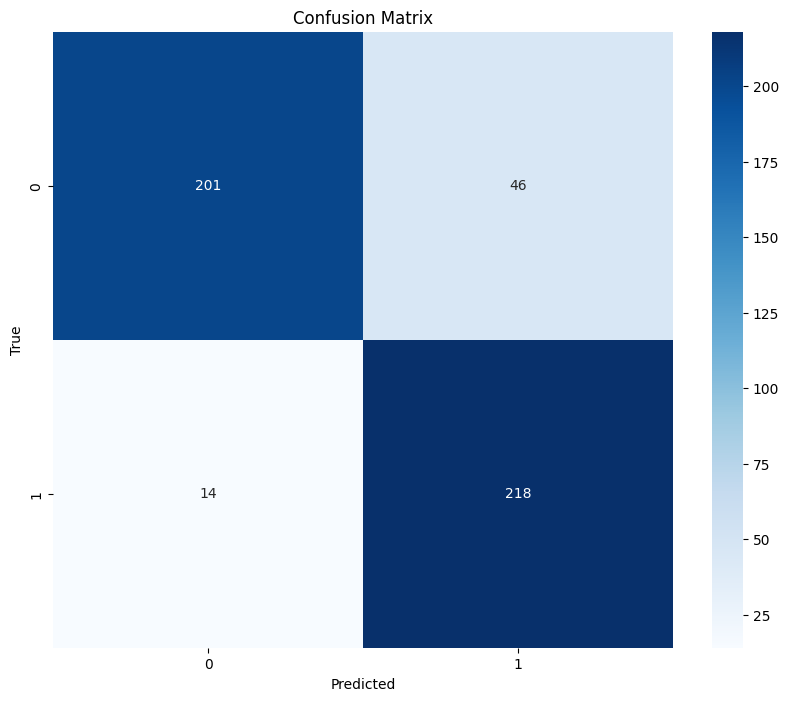

In [ ]:
model.plot_confusion_matrix(y_test)

In [ ]:
report = classification_report(y_test, model.preds, target_names=['Non Discours', 'Discours'])

In [ ]:
print(report)

              precision    recall  f1-score   support

Non Discours       0.93      0.81      0.87       247
    Discours       0.83      0.94      0.88       232

    accuracy                           0.87       479
   macro avg       0.88      0.88      0.87       479
weighted avg       0.88      0.87      0.87       479



## ii. Utilisation

In [ ]:
from transformers import CamembertForSequenceClassification, CamembertTokenizer

# Charger le modèle et le tokenizer depuis Hugging Face Hub
model = CamembertForSequenceClassification.from_pretrained(repo_id)
tokenizer = CamembertTokenizer.from_pretrained(repo_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/764 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/374 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
df = pd.read_csv("titres_ed_lemonde.csv", encoding = 'utf-8', sep = ";")

In [ ]:
df['Full_Text_clean'].head()

,Full_Text_clean
0,"""Pascal : La première question semble évidente..."
1,"""Que retient-on des sorties médiatiques récent..."
2,"""Souvent, sur les affiches de campagne, son no..."
3,"""Le XIVe Congrès du Front nationals'est ouvert..."
4,"""Des incidents entre forces de l'ordre et une ..."


In [ ]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Date', 'Titre', 'Thème', 'Lien',
       'Catégorie', 'Pays', 'politique', 'NER_results', 'Noms', 'Organisation',
       'Type', 'Nuance', 'Parti', 'Presence', 'Full_Text', 'Full_Text_clean'],
      dtype='object')

In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
df.dropna(subset = ['Full_Text_clean'], inplace = True)

In [ ]:
# Appliquer la fonction make_sentences sur la colonne 'full_text_clean'
df['sentences'] = df['Full_Text_clean'].progress_apply(make_sentences)

# Exploser la colonne 'sentences' pour avoir une ligne par phrase
df_exploded = df.explode('sentences')

100%|██████████| 5525/5525 [11:25<00:00,  8.06it/s]


In [ ]:
df_exploded.dropna(subset = "sentences", inplace = True)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [ ]:
def get_predictions(to_predict) :
    model.eval()
    inputs = tokenizer(to_predict, padding=True, truncation=True, return_tensors='pt')
    dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'])
    loader = DataLoader(dataset, batch_size=8, shuffle=False)

    all_preds = []

    with torch.no_grad():
        for batch in tqdm(loader, desc='Predicting', leave=False):
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())

    return all_preds

In [ ]:
to_predict = df_exploded['sentences'].tolist()
predictions = get_predictions(to_predict)
df_exploded['discours'] = predictions
df_exploded.to_csv("/content/drive/MyDrive/Internship/articles_ed.csv", index = False, sep = ";", encoding = 'utf-8')


# 4- Suite

## o. Imports et fonctions

In [ ]:
!pip install pandas matplotlib wordcloud nltk
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 65.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Internship/articles_ed.csv", sep = ";", encoding = 'utf-8')

In [ ]:
#df = pd.read_csv("titres_ed_lemonde.csv", sep = ";", encoding = "utf-8")

In [ ]:
import matplotlib.pyplot as plt
#from wordcloud import WordCloud
#import nltk
#from nltk.corpus import stopwords
#from sklearn.feature_extraction.text import CountVectorizer
import string
import spacy
import tqdm
from tqdm import tqdm

In [ ]:
!pip install pyLDAvis

In [ ]:
import re
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
import warnings
import pyLDAvis

In [ ]:
def preprocess(spacy_docs) :
    docs = []
    for doc in spacy_docs:
      tokens = []
      for token in doc:
          if len(token.orth_) > 3 and not token.is_stop and token.pos_ != "PROPN": # prétraitements 1 et 2
              tokens.append( token.lemma_.lower() )  # TODO: prétraitements 3 et 4
      docs.append( tokens )
    return docs

def get_bigram(docs):
    # Convertir chaque document en une liste de chaînes de caractères
    bigram = Phrases(docs, min_count=10)
    for index in range(len(docs)):
        for token in bigram[docs[index]]:
            if '_' in token:  # les bigrammes sont reconnus par "_" qui concatène les mots
                docs[index].append(token)
    return docs

def make_dic(docs) :
    dictionary = Dictionary(docs)
    print('Nombre de mots uniques dans les documents initiaux :', len(dictionary))
    dictionary.filter_extremes(no_below=3, no_above=0.25)
    print('Nombre de mots uniques dans les documents après avoir enlevé les mots fréquents/peu fréquents :', len(dictionary))
    return dictionary

def make_corpus (docs) :
    corpus = [ dictionary.doc2bow(doc) for doc in docs]
    return corpus

In [ ]:
def make_model(texts) :
    texts = texts[texts.notnull()]
    spacy_doc = list(nlp.pipe(texts))
    docs = preprocess(spacy_doc)
    docs = get_bigram(docs)
    dictionary = make_dic(docs)
    corpus = make_corpus(docs)
    model_list, coherence_values = [], []
    for num_topics in tqdm(range(2, 20, 2), desc = "Calcul du nombre de topics optimal : " ):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=docs, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    # Trouver le nombre de topics avec la cohérence maximale
    optimal_num_topics = range(2, 20, 2)[coherence_values.index(max(coherence_values))]
    print("Le nombre optimal de topics est" + str(optimal_num_topics))
    index = (optimal_num_topics // 2) - 1  # Calculer l'index correspondant dans model_list

    model = model_list[index]  # Récupérer le modèle correspondant
    print("Voici les mots les plus fréquents pour chaque topic : ")
    for (topic, words) in model.print_topics():
        print("***********")
        print("* topic", topic+1, "*")
        print("***********")
        print(topic+1, ":", words)
        print()
    return model, corpus, dictionary

def interactive_lda(model, corpus, dictionary) :
    pyLDAvis.enable_notebook()
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    pyLDAvis.gensim_models.prepare(model, corpus, dictionary, sort_topics=False)

def get_topic_dominant(model, corpus) :
    doc_topics = [model.get_document_topics(bow) for bow in corpus]
    dominant_topics = []
    dominant_probs = []
    for topics in doc_topics:
        dominant_topic, prob = max(topics, key=lambda x: x[1])
        dominant_topics.append(dominant_topic)
        dominant_probs.append(prob)
    return dominant_topics, dominant_probs

def print_text_topic(df,num_topic) :
    # Trier les documents par topic dominant et probabilité
    df_sorted = df.sort_values(by=['Dominant_Topic', 'Topic_Probability'], ascending=[True, False])

    # Obtenir les documents les plus représentatifs pour chaque topic
    representative_docs = df_sorted.groupby('Dominant_Topic').head(10)  # Par exemple, les 5 premiers documents par topic

    text = representative_docs[representative_docs['Dominant_Topic'] == num_topic]['Discours_Concaténé']
    titre = representative_docs[representative_docs['Dominant_Topic'] == num_topic]['Titre']
    for text, titre in zip(text, titre) :
      print(titre)
      print(text)

## i. Reproduction
https://curiousml.github.io/teaching/DSA/dsa_nlp_tp_corr.html

In [ ]:
# Charger le modèle français de spaCy
nlp = spacy.load("fr_core_news_sm")
tqdm.pandas()

In [ ]:
# Conversion de la colonne Date en datetime et extraction de l'année
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_1990_2000 = df[(df['Year'] >= 1990) & (df['Year'] <= 2000)]
df_2001_2010 = df[(df['Year'] >= 2001) & (df['Year'] <= 2010)]
df_2010_2023 = df[(df['Year'] >= 2010) & (df['Year'] <= 2023)]
texts_1 = df_1990_2000['Full_Text']
texts_2 = df_2001_2010['Full_Text']
texts_3 = df_2010_2023['Full_Text']
texts_1 = texts_1[texts_1.notnull()]
texts_2 = texts_2[texts_2.notnull()]
texts_3 = texts_3[texts_3.notnull()]
spacy_doc1 = list(nlp.pipe(texts_1))
spacy_doc2 = list(nlp.pipe(texts_2))
spacy_doc3 = list(nlp.pipe(texts_3))
list_docs = [spacy_doc1, spacy_doc2, spacy_doc3]

In [ ]:
df = df[df["Full_Text"].notnull()]

In [ ]:
texts = df['Full_Text']
texts = texts[texts.notnull()]
spacy_doc = list(nlp.pipe(texts))

In [ ]:
# prompt: sauvegarder list_docs

import pickle
with open('/content/drive/MyDrive/Internship/list_docs.pkl', 'wb') as f:
  pickle.dump(spacy_doc, f)


In [ ]:
# prompt: ouvrir list_docs.pkl

import pickle
with open('/content/drive/MyDrive/Internship/list_docs.pkl', 'rb') as f:
  spacy_doc = pickle.load(f)


Nous avons maintenant une liste de documents spaCy. Nous allons transformer chaque document spaCy en une liste de tokens. Au lieu des tokens originaux, nous allons travailler avec les lemmes à la place. Cela permettra à notre modèle de mieux généraliser. En effet, nous voulons par exemple que "continuation" et "continuations" représentent la même signification.

Voici la liste complète des prétraitements :

1.   supprimer tous les mots de moins de 3 caractères
2.   supprimer tous les stop-words
3. lemmatiser les mots restants
4. mettre en minuscule
5. enlever les noms propres


In [ ]:
def preprocess(spacy_docs) :
    docs = []
    for doc in spacy_docs:
      tokens = []
      for token in doc:
          if len(token.orth_) > 3 and not token.is_stop and token.pos_ != "PROPN": # prétraitements 1 et 2
              tokens.append( token.lemma_.lower() )  # TODO: prétraitements 3 et 4
      docs.append( tokens )
    return docs

docs = preprocess(spacy_doc)

In [ ]:
print(docs[2])

['affiche', 'campagne', 'éclipse', 'parti', 'incarnation', 'pourtant', 'samedi', 'janvier', 'quitter', 'présidence', 'front', 'national', 'parti', 'cofonder', '1972', 'porter', 'jusque', 'porte', 'jamais', 'réussir', 'franchir', 'fois', 'histoire', 'parti', 'extrême', 'droite', 'perdre', 'leader', 'historique', 'restera\\"présider', 'ancien', 'figure', 'classe', 'politique', 'français', 'lecurriculum', 'vitaepourrer', 'résumer', 'mot', 'jamais', 'cacher', 'défendre', 'l\'\\"algérie', 'française\\', '1958', 'refuser', 'voter', 'plein', 'pouvoir', 'engager', 'volontaire', 'algérie', 'français', 'accusation', 'torture', 'objet', 'année', '1980', 'jamais', 'reconnaître', 'président', 'ailleurs', 'gagner', 'nombre', 'procès', 'diffamation', 'sujet', 'jusque', '2002', 'attaquéle', 'mondepour', 'article', 'état', 'témoignage', 'concordant', 'participation', 'torture', 'guerre', 'chambre', 'correctionnel', 'reconnu\\"la', 'crédibiliter', 'certaine\\"de', 'fait', 'chef', 'défendre', '1985', 'ex

In [ ]:
def get_bigram(docs):
    # Convertir chaque document en une liste de chaînes de caractères
    bigram = Phrases(docs, min_count=10)
    for index in range(len(docs)):
        for token in bigram[docs[index]]:
            if '_' in token:  # les bigrammes sont reconnus par "_" qui concatène les mots
                docs[index].append(token)
    return docs

# Appliquer la fonction à chaque document
#list_docs = [get_bigram([doc]) for doc in list_docs]
docs = get_bigram(docs)


In [ ]:
def make_dic(docs) :
    dictionary = Dictionary(docs)
    print('Nombre de mots unique dans les documents initiaux :', len(dictionary))


    dictionary.filter_extremes(no_below=3, no_above=0.25)
    print('Nombre de mots unique dans les documents après avoir enlevé les mots fréquents/peu fréquents :', len(dictionary))

    return dictionary

#dictionaries = [make_dic(doc) for doc in list_docs]
dictionary = make_dic(docs)

Nombre de mots unique dans les documents initiaux : 53598
Nombre de mots unique dans les documents après avoir enlevé les mots fréquents/peu fréquents : 15416


In [ ]:
def make_corpus (docs) :
    corpus = [ dictionary.doc2bow(doc) for doc in docs]
    return corpus

#corpus = [make_corpus(doc) for doc in list_docs]
corpus = make_corpus(docs)

On détermine d'abord le nombre de topics optimal

In [ ]:
# Construire plusieurs modèles LDA avec différents nombres de topics
model_list, coherence_values = [], []
for num_topics in tqdm(range(2, 20, 2)):
    model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=docs, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

# Trouver le nombre de topics avec la cohérence maximale
optimal_num_topics = range(2, 20, 2)[coherence_values.index(max(coherence_values))]


100%|██████████| 9/9 [04:13<00:00, 28.20s/it]


In [ ]:
index = (optimal_num_topics // 2) - 1  # Calculer l'index correspondant dans model_list

model = model_list[index]  # Récupérer le modèle correspondant


In [ ]:
for (topic, words) in model.print_topics():
    print("***********")
    print("* topic", topic+1, "*")
    print("***********")
    print(topic+1, ":", words)
    print()

***********
* topic 1 *
***********
1 : 0.029*"européen" + 0.007*"parlement" + 0.007*"pays" + 0.007*"etat" + 0.006*"député" + 0.006*"droit" + 0.005*"parlement_européen" + 0.004*"euro" + 0.004*"parlementaire" + 0.004*"gouvernement"

***********
* topic 2 *
***********
2 : 0.013*"voix" + 0.013*"coalition" + 0.012*"liste" + 0.011*"démocrate" + 0.010*"obtenir" + 0.010*"conservateur" + 0.009*"gouvernement" + 0.009*"scrutin" + 0.008*"formation" + 0.008*"tête"

***********
* topic 3 *
***********
3 : 0.005*"falloir" + 0.004*"heure" + 0.003*"discours" + 0.003*"question" + 0.003*"être" + 0.003*"place" + 0.003*"jamais" + 0.003*"chef" + 0.003*"journaliste" + 0.003*"savoir"

***********
* topic 4 *
***********
4 : 0.008*"campagne" + 0.007*"front_national" + 0.006*"maire" + 0.005*"régional" + 0.005*"liste" + 0.004*"municipal" + 0.004*"présidentiel" + 0.004*"ville" + 0.004*"mouvement" + 0.004*"tête"

***********
* topic 5 *
***********
5 : 0.042*"tour" + 0.021*"second" + 0.018*"gauche" + 0.016*"seco

In [ ]:
!pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.1 MB/s eta 0:00:00


In [ ]:
# Sauvegarde du modèle dans un fichier
with open("/content/drive/MyDrive/Internship/modele_lineaire.pkl", "wb") as fichier:
    pickle.dump(model, fichier)

In [ ]:
import pyLDAvis.gensim_models
import warnings

In [ ]:
pyLDAvis.enable_notebook()
warnings.filterwarnings("ignore", category=DeprecationWarning)

pyLDAvis.gensim_models.prepare(model, corpus, dictionary, sort_topics=False)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.067239  0.129464       1        1   6.951991
1      0.186249 -0.117480       2        1   2.534599
2      0.003194  0.028122       3        1  15.723148
3      0.109351  0.020693       4        1  14.729134
4      0.241747 -0.113207       5        1   5.366459
5     -0.139697 -0.072452       6        1   6.417130
6      0.026782  0.102719       7        1  16.095547
7     -0.051513  0.136701       8        1   4.964812
8      0.144706  0.071399       9        1   6.628024
9     -0.084314 -0.070989      10        1   2.398605
10    -0.138450  0.064711      11        1   2.833056
11    -0.140310 -0.033679      12        1   9.769592
12    -0.127361 -0.202552      13        1   1.134096
13    -0.097623  0.056551      14        1   4.453806, topic_info=          Term         Freq        Total Category  logprob  loglift
247       tour  1773.000000  1773.000000  Default  30.0000  30.0000
517   européen  1811.000000  1811.000000  Default  29.0000  29.0000
111     gauche  1282.000000  1282.000000  Default  28.0000  28.0000
931     groupe  1271.000000  1271.000000  Default  27.0000  27.0000
257       voix  1003.000000  1003.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
578      monde    61.540363   938.045186  Topic14  -6.0636   0.3873
327    exemple    52.555619   387.067164  Topic14  -6.2215   1.1147
13    ailleurs    55.328892   743.657785  Topic14  -6.1700   0.5131
496    devenir    53.960392   746.088954  Topic14  -6.1951   0.4848
97   expliquer    53.981404  1029.415769  Topic14  -6.1947   0.1633

[1097 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
13300      2  0.749843       14,6
3291       5  0.926132    1ertour
14273      4  0.921417  2012_2017
10311      1  0.054287       2022
10311      3  0.102542       2022
...      ...       ...        ...
679        9  0.070570      œuvre
679       11  0.097454      œuvre
679       12  0.493990      œuvre
679       13  0.016802      œuvre
679       14  0.060489      œuvre

[4393 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

In [ ]:
# Nous en affichons que 4
n_doc = 3
i = 0
for (text, doc) in zip(texts_1[:n_doc], docs[:n_doc]):
    i += 1
    print("***********")
    print("* doc", i, "  *")
    print("***********")
    print(text)
    print([(topic+1, prob) for (topic, prob) in model[dictionary.doc2bow(doc)] if prob > 0.1])
    print()

***********
* doc 1   *
***********
""
[(9, 0.5171865), (12, 0.33092695)]

***********
* doc 2   *
***********
"Avec cette année 1992 prend fin mon aventure à la tête de Minute-la France \", annonce M. Serge Martinez dans l'éditorial du dernier numéro (daté 30 décembre-5 janvier) de l'hebdomadaire d'extrême droite, dont il avait pris la direction en janvier 1990. \" Une nouvelle équipe, précise M. Martinez, prend en main les destinées de notre journal, sous la direction de Gérald Penciolelli, avec lequel j'ai signé un accord qui réunit dans un même groupe les titres de la presse nationale que vous connaissez déjà : le Choc du mois, Enquête sur l'histoire, la Lettre de Magazine-hebdo. \" Cette lettre confidentielle est rédigée par M. Jean-Claude Valla. Souhaitant \" bon vent \" à la publication qu'il dirigeait, M. Martinez écrit que \" la télévision et son information prédigérée, les radios et leurs journaux en pilules, la presse écrite prosternée devant les lobbies dispensateurs de pub

On veut récupérer le topic dominant pour chaque document

In [ ]:
doc_topics = [model.get_document_topics(bow) for bow in corpus]

dominant_topics = []
dominant_probs = []
for topics in doc_topics:
    dominant_topic, prob = max(topics, key=lambda x: x[1])
    dominant_topics.append(dominant_topic)
    dominant_probs.append(prob)
df['Dominant_Topic'] = dominant_topics
df['Topic_Probability'] = dominant_probs


In [ ]:
df.to_csv("/content/drive/MyDrive/Internship/articles_ed_topics.csv", index = False, sep = ";", encoding = 'utf-8')

## ii. Interprétation

In [ ]:
import pandas as pd

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Full_Text,Discours_Concaténé,Titre,NER_results,Date,Lien,Type,Nuance,Parti,Presence,Dominant_Topic,Topic_Probability
0,""" Assemblée nationale, extrait de laséance du ...",L’ordre du jour appelle la discussion de la pr...,decheance votre texte n a pour but que de cour...,"[{'entity_group': 'ORG', 'score': 0.93922126, ...",2015-12-23,https://www.lemonde.fr/justice/article/2015/12...,"['gauche', 'ed']",['parti'],"['front national', 'parti socialiste']",2,10,0.324317
1,""" C’est un homme de l’ombre du FN qui continue...","« Je suis très étonné de ce résultat, disait-i...",bruno bilde mariniste de l ombre,NaN,2015-02-23,https://www.lemonde.fr/politique/article/2015/...,['ed'],['parti'],['front national'],1,17,0.384657
2,""" Doullens (Somme), envoyé spécial Marine Le P...",Le Pen assure avoir« très envie »de se présent...,marine le pen a tres envie d etre candidate au...,"[{'entity_group': 'PER', 'score': 0.99756473, ...",2015-03-05,https://www.lemonde.fr/politique/article/2015/...,['ed'],['parti'],['front national'],1,2,0.549493
3,""" En politique, certains itinéraires peuvent c...",« J’ai pris un café avec lui dans le 2earrondi...,sebastien chenu de nkm a le pen en passant par...,"[{'entity_group': 'PER', 'score': 0.99836445, ...",2015-04-17,https://www.lemonde.fr/politique/article/2015/...,"['droite', 'gauche', 'ed']","['sensibilite', 'parti']","['les republicains', 'divers ed', 'parti socia...",1,2,0.400298
4,""" Les Forbans, le groupe de rock français qui ...","D'ailleurs, le chanteur, Albert Kassabi alias ...",rock les forbans donnent un concert pour le co...,"[{'entity_group': 'ORG', 'score': 0.9586226, '...",2012-12-04,https://www.lemonde.fr/big-browser/article/201...,['ed'],['parti'],['front national'],2,17,0.247358


In [ ]:
# prompt: ouvrir articles_ed_topics.csv

df = pd.read_csv("/content/drive/MyDrive/Internship/articles_ed_topics.csv", sep = ";", encoding = 'utf-8')


In [ ]:
# Trier les documents par topic dominant et probabilité
df_sorted = df.sort_values(by=['Dominant_Topic', 'Topic_Probability'], ascending=[True, False])

# Obtenir les documents les plus représentatifs pour chaque topic
representative_docs = df_sorted.groupby('Dominant_Topic').head(10)  # Par exemple, les 5 premiers documents par topic


In [ ]:
def print_text_topic(df,num_topic) :
    # Trier les documents par topic dominant et probabilité
    df_sorted = df.sort_values(by=['Dominant_Topic', 'Topic_Probability'], ascending=[True, False])

    # Obtenir les documents les plus représentatifs pour chaque topic
    representative_docs = df_sorted.groupby('Dominant_Topic').head(10)  # Par exemple, les 5 premiers documents par topic

    text = representative_docs[representative_docs['Dominant_Topic'] == num_topic]['Discours_Concaténé']
    titre = representative_docs[representative_docs['Dominant_Topic'] == num_topic]['Titre']
    for text, titre in zip(text, titre) :
      print(titre)
      print(text)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print_text(2)


covoiturage avec des militants de haute loire pour un meeting de marine le pen
"La Haute-Loire, petit département rural, peine à attirer les ténors politiques. Ce constat, vrai pour les deux partis réputés en tête de la présidentielle, est encore plus aigu pour les plus petits partis (en tout cas en nombre de militants) comme le Front national. Aussi, rendez-vous était-il pris, samedi 7 avril, le long de la nationale 88 pour aller à trois ou quatre militants par voiture en direction de Lyon pour lemeeting de Marine Le Pen. \"Non mais tu te rends compte qu'en ce moment, il y a une vague de suicides en Italie et que personne n'en parle dans les médias !\", entame Roxanne, sitôt montée dans la voiture de Pierre Cheynet, le secrétaire fédéral du FN 43. Petite rousse énergique n'ayant pas sa langue dans la poche, Roxanne vient d'Italie et regarde le telegiornale presque tous les soirs. Des suicides économiques, explique-t-elle, comme en Grèce.\"C'est pour ne pas nuire à la campagne de Sarko

In [ ]:
topic_labels = {
    0: "Union Européenne",
    1: "International",
    2: "Divers",
    3: "Campagnes élections",
    4: "Résultats élections",
    5: "Culture", # misclassification
    6: "Condamnations justice",
    7: "Coeur de porc" , #bug
    8: "Assemblée Nationale",
    9: "Jeux vidéos", # misclassification
    10: "Finance et multinationales",# misclassification
    11: "Culture", # misclassification
    12: "Musique", # misclassification
    13: "Mal classifié"
}


In [ ]:
df['Topic_Label'] = df['Dominant_Topic'].map(topic_labels)

In [ ]:
# Filtrer pour les topics qui vous intéressent (par exemple, "Politics" et "Technology")
topics_of_interest = [0, 1, 2, 3, 4, 6, 8]
df_filtered = df[df['Dominant_Topic'].isin(topics_of_interest)]


In [ ]:
import matplotlib.pyplot as plt

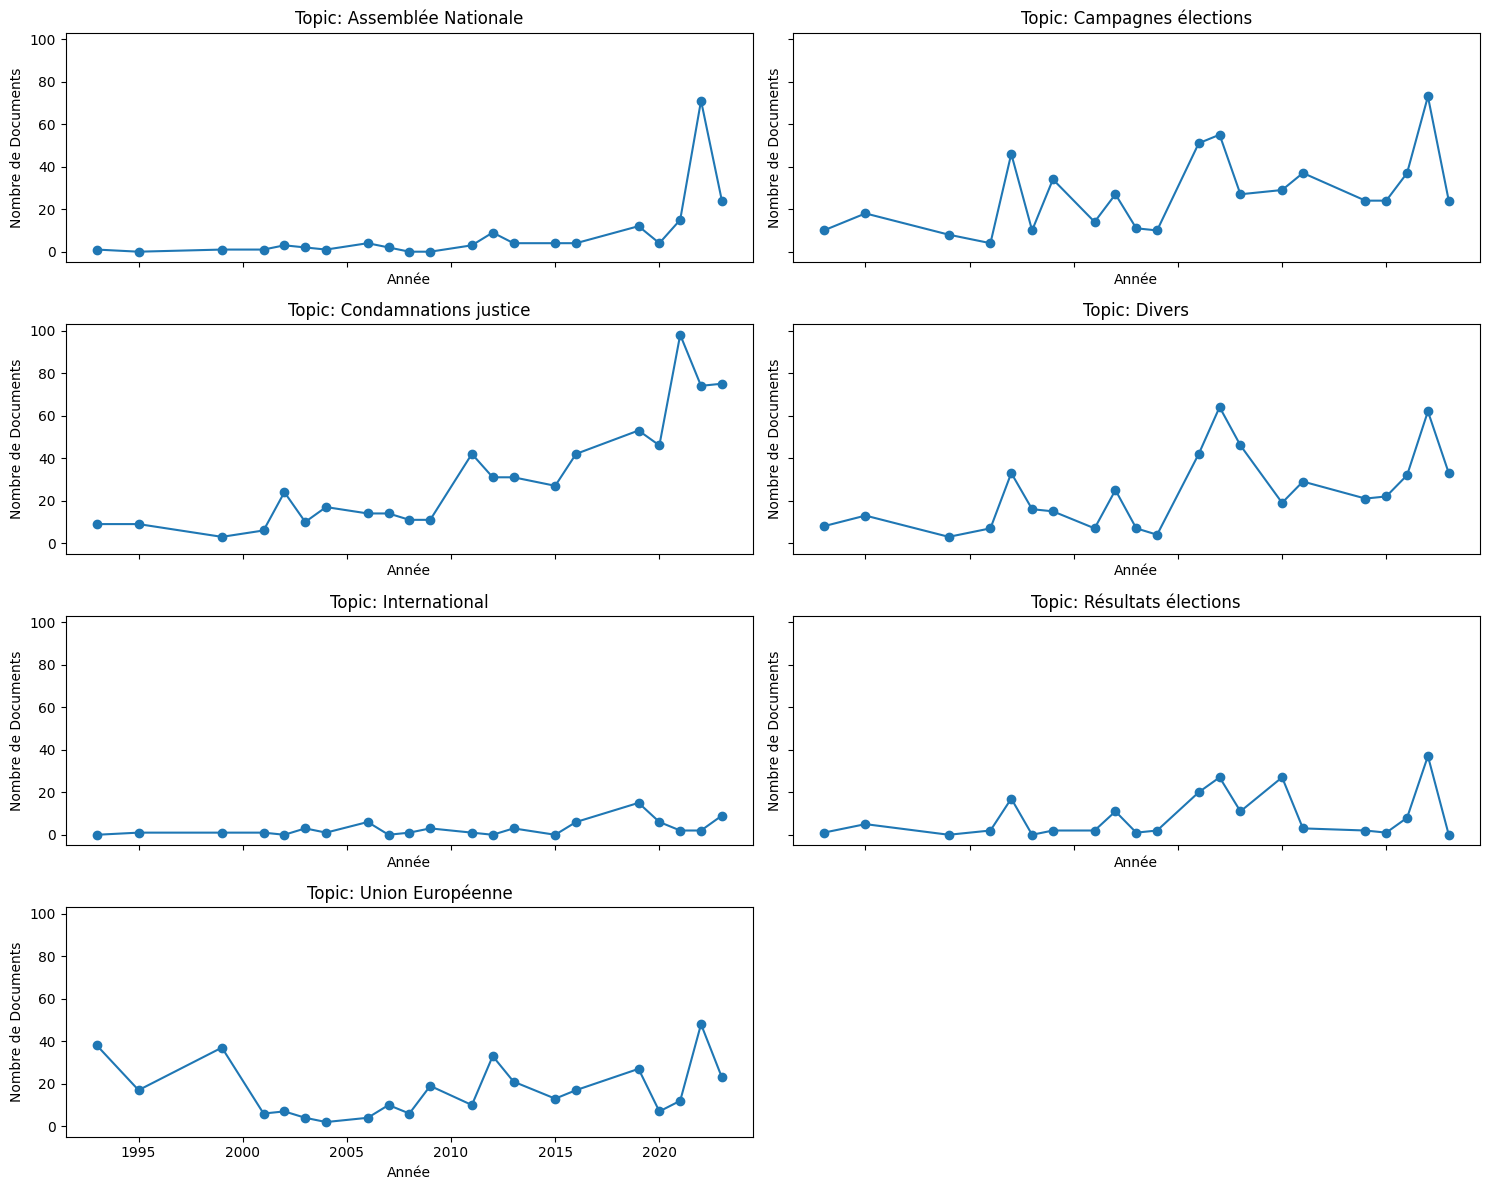

In [ ]:
# Calculer le nombre de documents par année et par topic
topic_evolution = df_filtered.groupby(['Year', 'Topic_Label']).size().unstack(fill_value=0)

# Initialiser une figure avec 7 subplots (2 lignes, 4 colonnes)
fig, axes = plt.subplots(4, 2, figsize=(15, 12), sharex=True, sharey=True)

# Aplatir les axes pour une itération facile
axes = axes.flatten()

# Créer un mini-graphe pour chaque topic
for i, topic in enumerate(topic_evolution.columns):
    axes[i].plot(topic_evolution.index, topic_evolution[topic], marker='o')
    axes[i].set_title(f"Topic: {topic}")
    axes[i].set_xlabel('Année')
    axes[i].set_ylabel('Nombre de Documents')

# Supprimer les axes vides si moins de 8 topics
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Limite : ça reflète plutôt le sujet de l'article que véritablement un changement dans le parti.

## iii. LDA sur les discours uniquement

In [ ]:
nlp = spacy.load("fr_core_news_sm")

In [ ]:
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Date', 'Titre', 'Thème', 'Lien',
       'Catégorie', 'Pays', 'politique', 'NER_results', 'Noms', 'Organisation',
       'Type', 'Nuance', 'Parti', 'Presence', 'Full_Text', 'Full_Text_clean',
       'sentences', 'discours'],
      dtype='object')

In [ ]:
# Filtrer les phrases qui sont des discours
df_discours = data[data['discours'] == 1]

# Concaténer les sentences pour chaque Full_text
df_discours = df_discours.groupby('Full_Text').agg({
    'sentences': ' '.join,
    'Titre': 'first',  # Exemple pour une autre colonne à garder
    'NER_results': 'first',
    'Date' : "first",
    "Lien" : "first",
    "Type" : "first",
    "Nuance": 'first',
    'Parti': 'first',
    'Presence' : 'first'
    # Continuez à ajouter les autres colonnes ici
}).reset_index()

# Renommer la colonne des discours concaténés
df_discours.rename(columns={'sentences': 'Discours_Concaténé'}, inplace=True)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_discours.head()

In [ ]:
texts = df_discours['Full_Text']
model, corpus, dictionary = make_model(texts)

Nombre de mots uniques dans les documents initiaux : 63080
Nombre de mots uniques dans les documents après avoir enlevé les mots fréquents/peu fréquents : 18290


Calcul du nombre de topics optimal : 100%|██████████| 9/9 [05:34<00:00, 37.20s/it]

Le nombre optimal de topics est18
Voici les mots les plus fréquents pour chaque topic : 
***********
* topic 1 *
***********
1 : 0.012*"émission" + 0.011*"chaîne" + 0.009*"conseil" + 0.008*"parole" + 0.008*"décision" + 0.007*"journaliste" + 0.007*"débat" + 0.007*"polémiste" + 0.006*"droit" + 0.006*"propos"

***********
* topic 2 *
***********
2 : 0.009*"police" + 0.009*"personne" + 0.008*"jeune" + 0.006*"homme" + 0.006*"manifestation" + 0.006*"samedi" + 0.006*"policier" + 0.005*"dimanche" + 0.005*"violence" + 0.005*"force"

***********
* topic 3 *
***********
3 : 0.013*"maire" + 0.009*"municipal" + 0.007*"général" + 0.007*"liste" + 0.007*"ville" + 0.006*"secrétaire" + 0.005*"conseiller" + 0.005*"frontiste" + 0.005*"militant" + 0.005*"élu"

***********
* topic 4 *
***********
4 : 0.031*"européen" + 0.015*"euro" + 0.009*"groupe" + 0.008*"million" + 0.008*"parlement" + 0.006*"affaire" + 0.006*"milliard" + 0.005*"société" + 0.005*"banque" + 0.005*"parlement_européen"

***********
* topic 5

In [ ]:
dominant_topic, dominant_prob = get_topic_dominant(model, corpus)
df_discours['Dominant_Topic'] = dominant_topic
df_discours['Topic_Probability'] = dominant_prob

In [ ]:
# prompt: enregistrer le modèle et df_discours

# Sauvegarde du modèle dans un fichier
with open("/content/drive/MyDrive/Internship/modele_discours.pkl", "wb") as fichier:
    pickle.dump(model, fichier)

# Sauvegarde du DataFrame df_discours
df_discours.to_csv("/content/drive/MyDrive/Internship/df_discours.csv", index=False, sep=";", encoding='utf-8')


In [ ]:
# prompt: ouvrir le modèle et df_discours

import pickle

# Charger le modèle LDA
with open("/content/drive/MyDrive/Internship/modele_discours.pkl", "rb") as fichier:
    model = pickle.load(fichier)

# Charger le DataFrame df_discours
df = pd.read_csv("/content/drive/MyDrive/Internship/df_discours.csv", sep=";", encoding='utf-8')

# Conversion de la colonne Date en datetime et extraction de l'année
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
model.num_topics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


18

In [ ]:
# Dictionnaire pour stocker les word clouds
wordclouds = {}

# Générer un Word Cloud pour chaque topic
for i in range(model.num_topics):
    topic_words = dict(model.show_topic(i, 30))  # Obtenir les 30 mots principaux du topic

    # Créer le Word Cloud et le stocker dans le dictionnaire avec le nom 'wordcloud_i'
    wordclouds[f'wordcloud_{i}'] = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def print_wordcloud(num_topic) :
    # Obtenir le Word Cloud correspondant au topic spécifié
    wordcloud = wordclouds[f'wordcloud_{num_topic}']

    # Afficher le Word Cloud
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud du topic {num_topic}')
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print_text_topic(df_discours, 1)

turquie en images un attentat suicide au c ur d ankara
Le ministère de l’intérieur turc a rapidement qualifié l’explosion d’« attentat terroriste ». Selon le ministre de l’Intérieur, deux policiers ont été légèrement blessés dans l’attaque perpétrée par« deux terroristes », dont l’un« s’est fait exploser »et l’autre a été« neutralisé ».
une conference sur la palestine prise pour cible par l ultradroite a lyon trois blesses legers
Une personne a été interpellée dans les rangs de l’ultradroite, a précisé la préfecture en« condamnant fermement les violences commises ». Christophe Oberlin, un chirurgien qui se rend régulièrement à Gaza pour y opérer des victimes de blessures de guerre et qui venait présenter ses deux derniers livres, a raconté à l’AFP que des personnes« tapaient avec des bâtons »pour enfoncer la porte de la salle dans laquelle se tenait la conférence, sans parvenir à y entrer. Selon plusieurs participants, la salle de 120 places était« comble ».Des enfants et des personnes

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


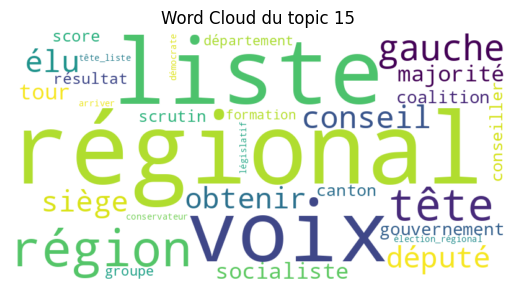

In [ ]:
print_wordcloud(15)

In [ ]:
topic_labels = {
    0: "Censure",
    1: "Violence", #violences civils/police, émeutes
    2: "Candidatures élections",
    3: "Prêts",
    4: "", #HS
    5: "Stratégie électorale", #second tour, coalitions, vote et surtout consignes de vote
    6: "Condmnations (haine raciale, négationnisme)",
    7: "", #HS
    8: "",#HS international
    9: "Condamnations diverses", #escroquerie, financement de campagne, publication d'images violentes
    10: "",#HS affaires françaises
    11: "", #1 seul article
    12: "Organisations", #d'extrême droite ou antifa
    13: "Attentats",
    14: "Exclusions du parti",
    15: "Résultats élections",
    16: "", #HS coeurs artificiels
    17: "", #HS
    18: "",
    19: ""

}

In [ ]:
df['Topic_Label'] = df['Dominant_Topic'].map(topic_labels)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Filtrer pour les topics qui vous intéressent (par exemple, "Politics" et "Technology")
topics_of_interest = [0, 1, 2, 5, 6, 9, 12, 13, 14, 15]
df_filtered = df[df['Dominant_Topic'].isin(topics_of_interest)]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_filtered.columns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['Full_Text', 'Discours_Concaténé', 'Titre', 'NER_results', 'Date',
       'Lien', 'Type', 'Nuance', 'Parti', 'Presence', 'Dominant_Topic',
       'Topic_Probability', 'Year'],
      dtype='object')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


IndexError: index 8 is out of bounds for axis 0 with size 8

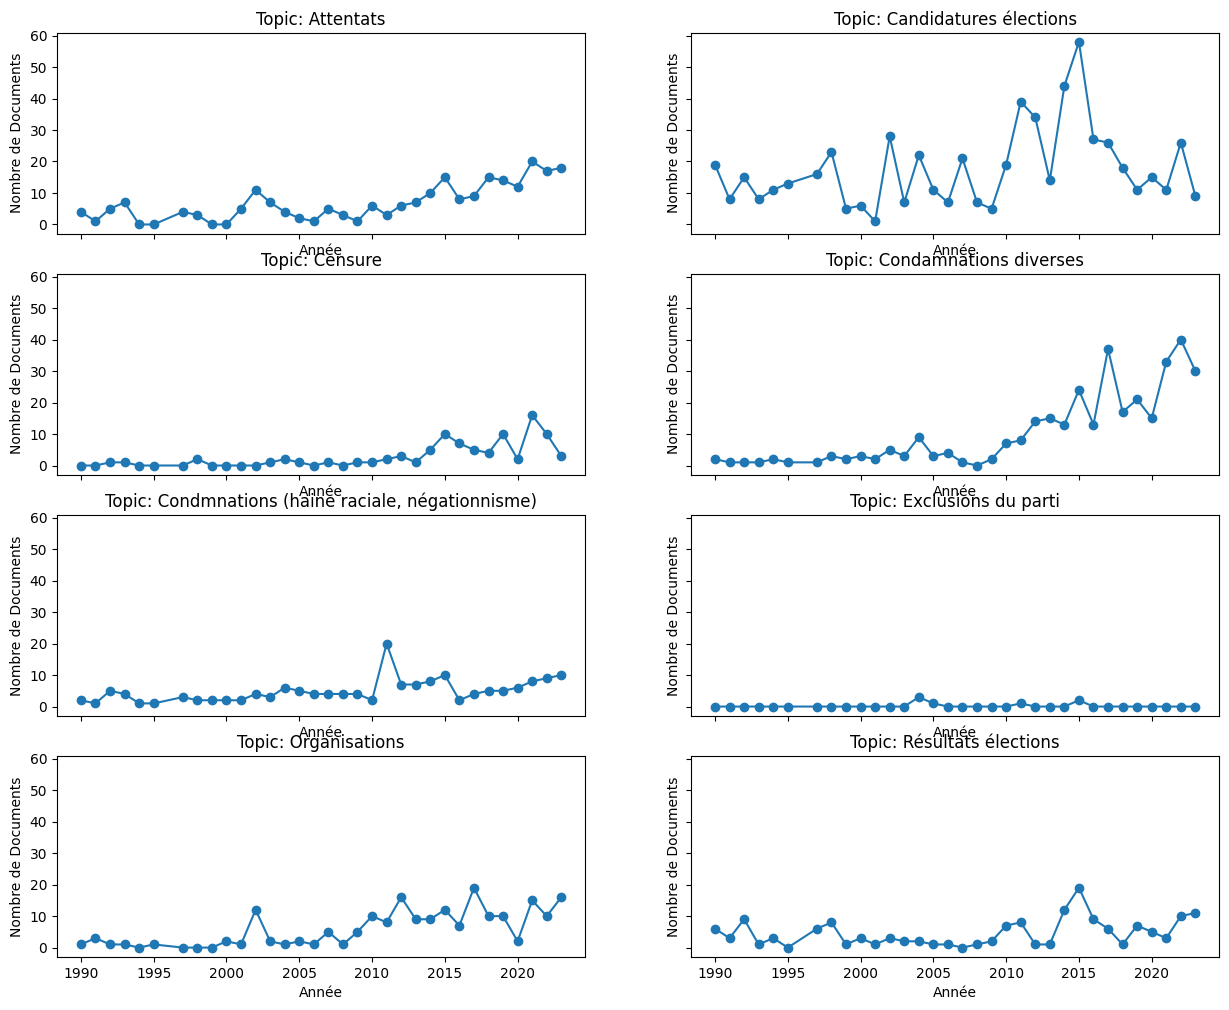

In [ ]:
# Calculer le nombre de documents par année et par topic
topic_evolution = df_filtered.groupby(['Year', 'Topic_Label']).size().unstack(fill_value=0)

# Initialiser une figure avec 7 subplots (2 lignes, 4 colonnes)
fig, axes = plt.subplots(4, 2, figsize=(15, 12), sharex=True, sharey=True)

# Aplatir les axes pour une itération facile
axes = axes.flatten()

# Créer un mini-graphe pour chaque topic
for i, topic in enumerate(topic_evolution.columns) :
    axes[i].plot(topic_evolution.index, topic_evolution[topic], marker='o')
    axes[i].set_title(f"Topic: {topic}")
    axes[i].set_xlabel('Année')
    axes[i].set_ylabel('Nombre de Documents')

# Supprimer les axes vides si moins de 8 topics
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


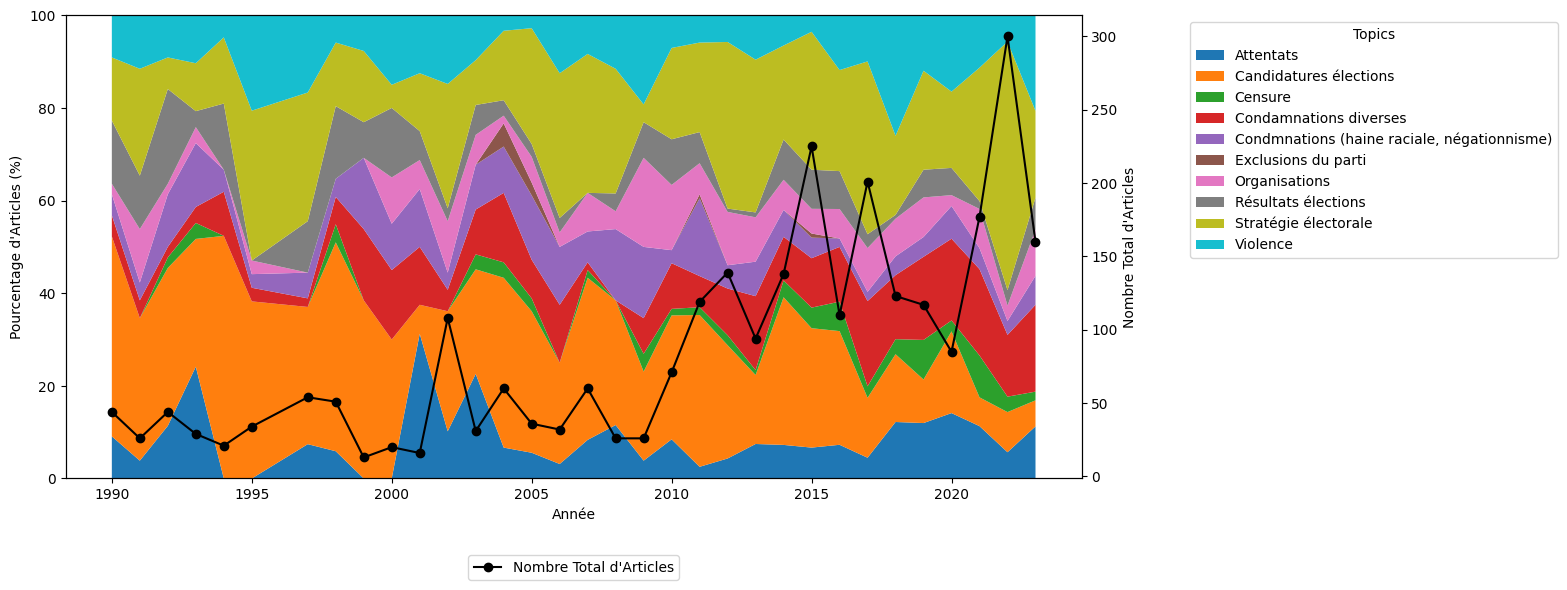

In [ ]:
# Calculer le pourcentage de documents par topic et par année
topic_evolution_pct = topic_evolution.div(topic_evolution.sum(axis=1), axis=0) * 100

# Calculer le nombre total d'articles par année
total_articles_per_year = topic_evolution.sum(axis=1)

# Créer une figure rectangulaire (plus long que large)
fig, ax1 = plt.subplots(figsize=(16, 6))  # Ajusté pour être rectangulaire

# Graphique à aires empilées (pourcentages)
ax1.stackplot(topic_evolution_pct.index, topic_evolution_pct.T, labels=topic_evolution_pct.columns)
ax1.set_ylabel("Pourcentage d'Articles (%)")
ax1.set_xlabel("Année")
ax1.set_ylim(0, 100)

# Ajouter un deuxième axe pour le nombre total d'articles
ax2 = ax1.twinx()
ax2.plot(total_articles_per_year.index, total_articles_per_year, color='black', marker='o', label="Nombre Total d'Articles")
ax2.set_ylabel("Nombre Total d'Articles")

# Positionner la légende des topics sur la droite
ax1.legend(loc='upper left', bbox_to_anchor=(1.1, 1),
           title = "Topics")  # Légende des topics à droite
# Positionner la légende des articles sous le graphique
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15))  # Légende des articles en dessous

# Ajuster les marges pour éviter le chevauchement des éléments
plt.tight_layout()

# Afficher le graphique
plt.show()

In [ ]:
pyLDAvis.enable_notebook()
warnings.filterwarnings("ignore", category=DeprecationWarning)
pyLDAvis.gensim_models.prepare(model, corpus, dictionary, sort_topics=False)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.086621 -0.080816       1        1   2.372255
1      0.068339  0.074701       2        1   6.047837
2      0.089929 -0.065437       3        1   8.909915
3      0.047152 -0.062054       4        1   6.145904
4     -0.006931  0.226391       5        1   5.877059
5      0.109332 -0.074267       6        1  12.919896
6      0.091565 -0.021430       7        1   3.542591
7     -0.122375  0.194067       8        1   2.174612
8     -0.018362 -0.064313       9        1   1.869112
9      0.112862 -0.101628      10        1   7.297892
10     0.029618  0.048143      11        1  16.732052
11    -0.274583 -0.040908      12        1   0.209439
12     0.112992  0.005280      13        1   5.323760
13     0.048609  0.040497      14        1   5.947535
14    -0.281689 -0.173261      15        1   0.507426
15     0.007229 -0.168960      16        1   3.883908
16    -0.108167  0.073157      17        1   1.400765
17     0.007861  0.190837      18        1   8.838040, topic_info=           Term         Freq        Total Category  logprob  loglift
608    européen  2567.000000  2567.000000  Default  30.0000  30.0000
703   américain  1120.000000  1120.000000  Default  29.0000  29.0000
525       ville  1441.000000  1441.000000  Default  28.0000  28.0000
1959       tour  2552.000000  2552.000000  Default  27.0000  27.0000
1579       euro  1392.000000  1392.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1594      jeune   215.554028  1561.553583  Topic18  -5.8430   0.4459
703   américain   199.227707  1120.847807  Topic18  -5.9218   0.6987
434   connaître   182.899137   812.624676  Topic18  -6.0073   0.9348
151     falloir   189.595197  1566.190940  Topic18  -5.9713   0.3146
765       point   183.711393  1256.647804  Topic18  -6.0029   0.5033

[1381 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
12914      5  0.943460  1918
4544      17  0.973539  1932
1662       2  0.002511  2002
1662       3  0.077831  2002
1662       4  0.020085  2002
...      ...       ...   ...
406       13  0.069609  être
406       14  0.068096  être
406       16  0.006053  être
406       17  0.008323  être
406       18  0.074148  être

[5399 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

In [ ]:
from wordcloud import WordCloud

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Justifier le titre de chaque topic

# V- Sentiment analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import spacy
from transformers import pipeline
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [ ]:
df.to_csv("/content/drive/MyDrive/Internship/articles_ed_topics.csv", index = False, sep = ";", encoding = 'utf-8')

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Internship/articles_ed_topics.csv", sep = ";", encoding = 'utf-8')

In [ ]:
df.head()

,Full_Text,Discours_Concaténé,Titre,NER_results,Date,Lien,Type,Nuance,Parti,Presence,Dominant_Topic,Topic_Probability,Year,Topic_Label,sentences,original_index
0,""" Doullens (Somme), envoyé spécial Marine Le P...",Le Pen assure avoir« très envie »de se présent...,marine le pen a tres envie d etre candidate au...,"[{'entity_group': 'PER', 'score': 0.99756473, ...",2015-03-05,https://www.lemonde.fr/politique/article/2015/...,['ed'],['parti'],['front national'],1,2,0.549493,2015,Candidatures élections,['Le Pen assure avoir«\xa0très envie\xa0»de se...,2
1,""" En politique, certains itinéraires peuvent c...",« J’ai pris un café avec lui dans le 2earrondi...,sebastien chenu de nkm a le pen en passant par...,"[{'entity_group': 'PER', 'score': 0.99836445, ...",2015-04-17,https://www.lemonde.fr/politique/article/2015/...,"['droite', 'gauche', 'ed']","['sensibilite', 'parti']","['les republicains', 'divers ed', 'parti socia...",1,2,0.400298,2015,Candidatures élections,"['Il en voulait beaucoup à l’équipe de NKM.', ...",3
2,"""(Une version de cet article contenant des err...",Nous nous en excusons une nouvelle fois auprès...,le juge d application des peines au c ur des a...,NaN,2016-07-29,https://www.lemonde.fr/les-decodeurs/article/2...,['ed'],['groupuscule'],['unite radicale'],2,9,0.540262,2016,Condamnations diverses,['Nous nous en excusons une nouvelle fois aupr...,10
3,"""16 janvier 2011, congrès de Tours du Front na...","Un score dont il lâche ensuite qu'il""fait tair...",les numeros deux du fn 4 4 louis aliot le mari...,"[{'entity_group': 'ORG', 'score': 0.9904623, '...",2011-07-31,https://www.lemonde.fr/politique/article/2011/...,['ed'],['parti'],['front national'],3,2,0.434404,2011,Candidatures élections,"['Un score dont il lâche ensuite qu\'il""fait t...",12
4,"""19 mars 1962 : date du cessez-le-feu entre l’...",M. Sanchez a dit vouloir donner à la rue en qu...,le maire fn de beaucaire debaptise une rue nom...,"[{'entity_group': 'ORG', 'score': 0.9951582, '...",2015-11-27,https://www.lemonde.fr/politique/article/2015/...,['ed'],['parti'],['front national'],2,2,0.398528,2015,Candidatures élections,['M. Sanchez a dit vouloir donner à la rue en ...,14


In [ ]:
index_list = [2029, 393, 1107, 1370]

In [ ]:
!python -m spacy download fr_core_news_sm

In [ ]:
nlp = spacy.load("fr_core_news_sm")

In [ ]:
def make_sentences(text):
    # Traiter le texte avec le modèle spaCy
    doc = nlp(text)

    # Extraire les phrases détectées par spaCy
    sentences = [sent.text.strip() for sent in doc.sents]

    # Liste des phrases combinées
    combined_sentences = []
    i = 0

    while i < len(sentences):
        sentence = sentences[i].strip()

        # Gestion des guillemets ouvrants et fermants
        if sentence == '«' and i + 1 < len(sentences):
            # Fusionne le guillemet ouvrant avec la phrase suivante
            combined_sentences.append('« ' + sentences[i + 1].strip())
            i += 2  # Sauter la phrase suivante
        elif sentence == '»' and combined_sentences:
            # Ajouter un guillemet fermant à la phrase précédente
            combined_sentences[-1] += " »"
            i += 1
        elif sentence.startswith('»') and sentence.endswith('«'):
            # Déplacer le guillemet fermant vers la fin de la phrase précédente
            if combined_sentences:
                combined_sentences[-1] += " »"
            # Fusionner le reste de la phrase avec la suivante si elle existe
            sentence = sentence[1:-1].strip()
            if i + 1 < len(sentences):
                sentences[i + 1] = '« ' + sentences[i + 1].strip()
            combined_sentences.append(sentence)
            i += 1
        elif sentence.startswith('«') and sentence.endswith('»'):
            # Phrase complète avec guillemets
            combined_sentences.append(sentence)
            i += 1
        elif sentence.startswith('»') and combined_sentences:
            # Déplacer le guillemet fermant à la fin de la phrase précédente
            combined_sentences[-1] += " »"
            combined_sentences.append(sentence[1:].strip())
            i += 1
        elif sentence.endswith('«') and i + 1 < len(sentences):
            # Fusionner le guillemet ouvrant avec la phrase suivante
            combined_sentences.append(sentence[:-1].strip())
            sentences[i + 1] = '« ' + sentences[i + 1].strip()
            i += 1
        else:
            # Phrase normale
            combined_sentences.append(sentence)
            i += 1

    # Pass the combined sentences for final checks
    final_sentences = check_sentences(combined_sentences)

    return final_sentences

def check_sentences(sentences):
# Vérifier s'il y a au moins une phrase dans le texte
    if len(sentences) == 0:
        return False  # Pas de phrases
    final_sentences = []

    # Vérifier la première phrase : commence par une majuscule
    first_sentence = sentences[0].strip()
    if first_sentence[0].isupper():
        final_sentences.append(first_sentence)
    # Vérifier la dernière phrase : se termine par un signe de ponctuation
    last_sentence = sentences[-1].strip()
    if re.search(r'[.!?]$', last_sentence):
        final_sentences.append(last_sentence)
    i = 1
    while i < len(sentences) - 1 :
        final_sentences.append(sentences[i])
        i += 1
    return final_sentences

In [ ]:
df.columns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['Full_Text', 'Discours_Concaténé', 'Titre', 'NER_results', 'Date',
       'Lien', 'Type', 'Nuance', 'Parti', 'Presence', 'Dominant_Topic',
       'Topic_Probability', 'Year', 'Topic_Label'],
      dtype='object')

In [ ]:
tqdm.pandas(desc="progress-bar")

In [ ]:
# Appliquer la fonction make_sentence pour séparer les documents en phrases
df['sentences'] = df['Discours_Concaténé'].progress_apply(make_sentences)
# Conserver l'index d'origine en tant que nouvelle colonne
df['original_index'] = df.index

# Exploser les phrases pour avoir une ligne par phrase
dg = df.explode('sentences').reset_index(drop=True)

progress-bar: 100%|██████████| 2790/2790 [02:52<00:00, 16.15it/s]


In [ ]:
df.columns

Index(['Full_Text', 'Discours_Concaténé', 'Titre', 'NER_results', 'Date',
       'Lien', 'Type', 'Nuance', 'Parti', 'Presence', 'Dominant_Topic',
       'Topic_Probability', 'Year', 'Topic_Label', 'sentences',
       'original_index'],
      dtype='object')

In [ ]:
dg.columns

Index(['Full_Text', 'Discours_Concaténé', 'Titre', 'NER_results', 'Date',
       'Lien', 'Type', 'Nuance', 'Parti', 'Presence', 'Dominant_Topic',
       'Topic_Probability', 'Year', 'Topic_Label', 'sentences',
       'original_index'],
      dtype='object')

In [ ]:
dg = pd.read_csv('/content/drive/MyDrive/Internship/sentences_ed_topics.csv')

In [ ]:
# Supprimer les lignes où la colonne 'sentences' est vide ou égale à une chaîne vide
dg = dg[dg['sentences'].notna() & (dg['sentences'].str.strip() != '')]

In [ ]:
# Charger un pipeline de sentiment pour le français
sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment", device = "cuda")

# Diviser les phrases en batchs et appliquer le pipeline par lot
batch_size = 32  # Taille du batch
sentences = dg['sentences'].tolist()

# Appliquer le modèle par lots
sentiment_results = []
for i in tqdm(range(0, len(sentences), batch_size)):
    batch = sentences[i:i+batch_size]
    sentiment_results.extend(sentiment_pipeline(batch))

# Ajouter les résultats de sentiment au DataFrame
dg['Sentiment_Score'] = [result['label'] for result in sentiment_results]

In [ ]:
# prompt: enregistrer df sur le drive

# Enregistrer le DataFrame sur Google Drive
dg.to_csv('/content/drive/MyDrive/Internship/sentences_ed_topics.csv', index=False)


In [ ]:
dg.head()

,Full_Text,Discours_Concaténé,Titre,NER_results,Date,Lien,Type,Nuance,Parti,Presence,Dominant_Topic,Topic_Probability,Year,Topic_Label,sentences,original_index,Sentiment_Score
0,""" Doullens (Somme), envoyé spécial Marine Le P...",Le Pen assure avoir« très envie »de se présent...,marine le pen a tres envie d etre candidate au...,"[{'entity_group': 'PER', 'score': 0.99756473, ...",2015-03-05,https://www.lemonde.fr/politique/article/2015/...,['ed'],['parti'],['front national'],1,2,0.549493,2015,Candidatures élections,Le Pen assure avoir« très envie »de se présent...,0,4 stars
1,""" Doullens (Somme), envoyé spécial Marine Le P...",Le Pen assure avoir« très envie »de se présent...,marine le pen a tres envie d etre candidate au...,"[{'entity_group': 'PER', 'score': 0.99756473, ...",2015-03-05,https://www.lemonde.fr/politique/article/2015/...,['ed'],['parti'],['front national'],1,2,0.549493,2015,Candidatures élections,La gestion de la région pourrait être compliqu...,0,3 stars
2,""" Doullens (Somme), envoyé spécial Marine Le P...",Le Pen assure avoir« très envie »de se présent...,marine le pen a tres envie d etre candidate au...,"[{'entity_group': 'PER', 'score': 0.99756473, ...",2015-03-05,https://www.lemonde.fr/politique/article/2015/...,['ed'],['parti'],['front national'],1,2,0.549493,2015,Candidatures élections,Au détour d'un déplacement en Picardie dans le...,0,3 stars
3,""" Doullens (Somme), envoyé spécial Marine Le P...",Le Pen assure avoir« très envie »de se présent...,marine le pen a tres envie d etre candidate au...,"[{'entity_group': 'PER', 'score': 0.99756473, ...",2015-03-05,https://www.lemonde.fr/politique/article/2015/...,['ed'],['parti'],['front national'],1,2,0.549493,2015,Candidatures élections,"« J'ai très envie de partir à cette bataille,a...",0,5 stars
4,""" Doullens (Somme), envoyé spécial Marine Le P...",Le Pen assure avoir« très envie »de se présent...,marine le pen a tres envie d etre candidate au...,"[{'entity_group': 'PER', 'score': 0.99756473, ...",2015-03-05,https://www.lemonde.fr/politique/article/2015/...,['ed'],['parti'],['front national'],1,2,0.549493,2015,Candidatures élections,"Je suis une battante, et quand on est une batt...",0,5 stars


In [ ]:
# Trier le DataFrame par Sentiment_Score pour afficher les phrases les plus négatives
df_most_negative = dg.sort_values(by='Sentiment_Score', ascending=True).head(30)  # Afficher les 10 phrases les plus négatives

# Afficher les phrases les plus négatives une par une
for index, row in df_most_negative.iterrows():
    print(f"Phrase: {row['sentences']}")
    print(f"Sentiment: {row['Sentiment_Score']}")
    print('-' * 80)  # Ligne de séparation entre chaque phrase


Phrase: n’avoir« plus confiance »et dénoncent« les promesses en l’air, les promesses non tenues ».
Sentiment: 1 star
--------------------------------------------------------------------------------
Phrase: « Si on ne bouge pas »,la conséquence est la suivante, selon lui :« Soit nos pensions sont menacées, soit on accumule du déficit(
Sentiment: 1 star
--------------------------------------------------------------------------------
Phrase: les gens broient du noir, personne
Sentiment: 1 star
--------------------------------------------------------------------------------
Phrase: Condamnation unanime des exactions en Ukraine.
Sentiment: 1 star
--------------------------------------------------------------------------------
Phrase: Plusieurs candidats à la présidentielle ont réagi lundi auxscènes de carnage découvertes
Sentiment: 1 star
--------------------------------------------------------------------------------
Phrase: « Ces images sont insoutenables »,a déclaré Valérie Pécresse sur 

In [ ]:
def map_sentiment_score(label):
    if label == '1 star':
        return 1
    elif label == '2 stars':
        return 2
    elif label == '3 stars':
        return 3
    elif label == '4 stars':
        return 4
    elif label == '5 stars':
        return 5
    else:
        return None  # Gestion des cas inattendus

# Appliquer la fonction pour convertir les scores de sentiment en valeurs numériques
dg['Sentiment_Score'] = dg['Sentiment_Score'].apply(map_sentiment_score)


In [ ]:
# Agréger les résultats de sentiment par document en utilisant 'original_index'
df_aggregated = dg.groupby('original_index').agg({
    'Sentiment_Score': 'mean',  # Moyenne des scores de sentiment par document
    'sentences': 'count'  # Optionnel: compter le nombre de phrases par document
}).reset_index()

# Ajouter les résultats agrégés au DataFrame original (df)
df['Moyenne_Sentiment'] = df_aggregated['Sentiment_Score']
df['Nombre_Phrases'] = df_aggregated['sentences']

In [ ]:
df.head()

,Full_Text,Discours_Concaténé,Titre,NER_results,Date,Lien,Type,Nuance,Parti,Presence,Dominant_Topic,Topic_Probability,Year,Topic_Label,sentences,original_index,Moyenne_Sentiment,Nombre_Phrases
0,""" Doullens (Somme), envoyé spécial Marine Le P...",Le Pen assure avoir« très envie »de se présent...,marine le pen a tres envie d etre candidate au...,"[{'entity_group': 'PER', 'score': 0.99756473, ...",2015-03-05,https://www.lemonde.fr/politique/article/2015/...,['ed'],['parti'],['front national'],1,2,0.549493,2015,Candidatures élections,[Le Pen assure avoir« très envie »de se présen...,0,3.857143,7.0
1,""" En politique, certains itinéraires peuvent c...",« J’ai pris un café avec lui dans le 2earrondi...,sebastien chenu de nkm a le pen en passant par...,"[{'entity_group': 'PER', 'score': 0.99836445, ...",2015-04-17,https://www.lemonde.fr/politique/article/2015/...,"['droite', 'gauche', 'ed']","['sensibilite', 'parti']","['les republicains', 'divers ed', 'parti socia...",1,2,0.400298,2015,Candidatures élections,"[Il en voulait beaucoup à l’équipe de NKM., No...",1,2.846154,13.0
2,"""(Une version de cet article contenant des err...",Nous nous en excusons une nouvelle fois auprès...,le juge d application des peines au c ur des a...,NaN,2016-07-29,https://www.lemonde.fr/les-decodeurs/article/2...,['ed'],['groupuscule'],['unite radicale'],2,9,0.540262,2016,Condamnations diverses,[Nous nous en excusons une nouvelle fois auprè...,2,2.375000,8.0
3,"""16 janvier 2011, congrès de Tours du Front na...","Un score dont il lâche ensuite qu'il""fait tair...",les numeros deux du fn 4 4 louis aliot le mari...,"[{'entity_group': 'ORG', 'score': 0.9904623, '...",2011-07-31,https://www.lemonde.fr/politique/article/2011/...,['ed'],['parti'],['front national'],3,2,0.434404,2011,Candidatures élections,"[Un score dont il lâche ensuite qu'il""fait tai...",3,2.745098,51.0
4,"""19 mars 1962 : date du cessez-le-feu entre l’...",M. Sanchez a dit vouloir donner à la rue en qu...,le maire fn de beaucaire debaptise une rue nom...,"[{'entity_group': 'ORG', 'score': 0.9951582, '...",2015-11-27,https://www.lemonde.fr/politique/article/2015/...,['ed'],['parti'],['front national'],2,2,0.398528,2015,Candidatures élections,[M. Sanchez a dit vouloir donner à la rue en q...,4,1.000000,3.0


In [ ]:
data = df.copy()

In [ ]:
df = df[df['Nombre_Phrases'] > 1]

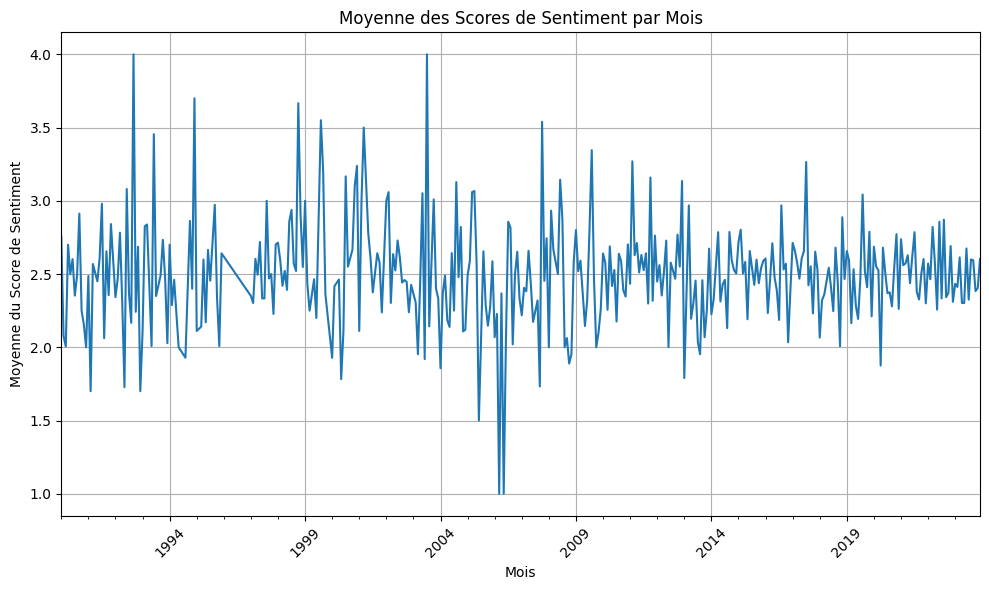

In [ ]:
# Grouper par mois et calculer la moyenne des scores de sentiment
# S'assurer que la colonne 'date' est au bon format datetime
df['datetime'] = pd.to_datetime(df['Date'])
df['month'] = df['datetime'].dt.to_period('M')  # Extraire l'année et le mois
monthly_sentiment = df.groupby('month')['Moyenne_Sentiment'].mean()

# Tracer la moyenne des sentiments par mois
plt.figure(figsize=(10, 6))
monthly_sentiment.plot(kind='line')
plt.title("Moyenne des Scores de Sentiment par Mois")
plt.xlabel("Mois")
plt.ylabel("Moyenne du Score de Sentiment")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

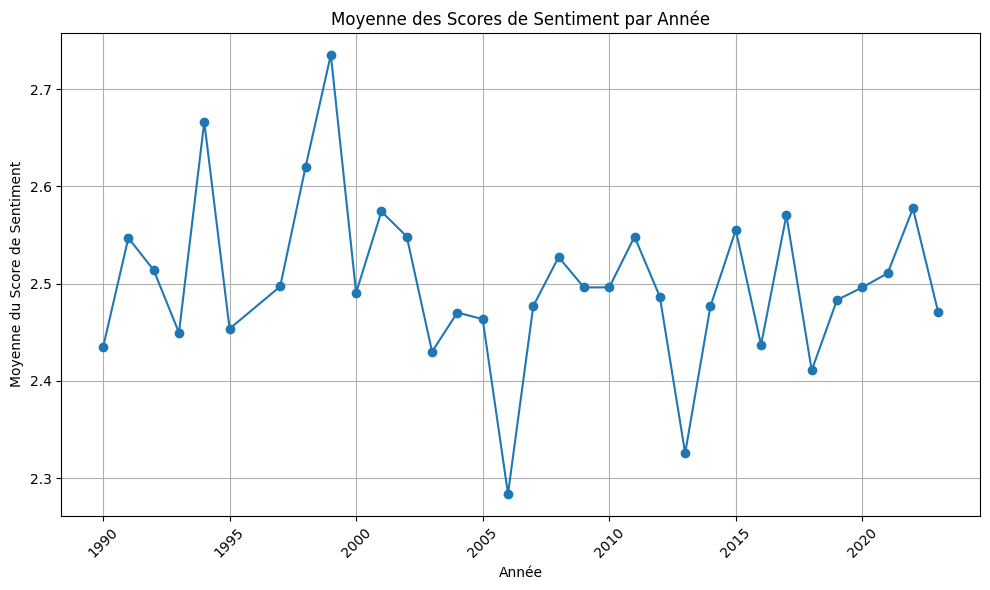

In [ ]:
# Grouper par année et calculer la moyenne des scores de sentiment
yearly_sentiment = df.groupby('Year')['Moyenne_Sentiment'].mean()

# Tracer la moyenne des sentiments par année après filtrage
plt.figure(figsize=(10, 6))
yearly_sentiment.plot(kind='line', marker='o')
plt.title("Moyenne des Scores de Sentiment par Année")
plt.xlabel("Année")
plt.ylabel("Moyenne du Score de Sentiment")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-18-d6e4c3ffca4b>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sentiment_count = df.groupby(['Dominant_Topic', 'Sentiment_Interval']).size().unstack(fill_value=0)


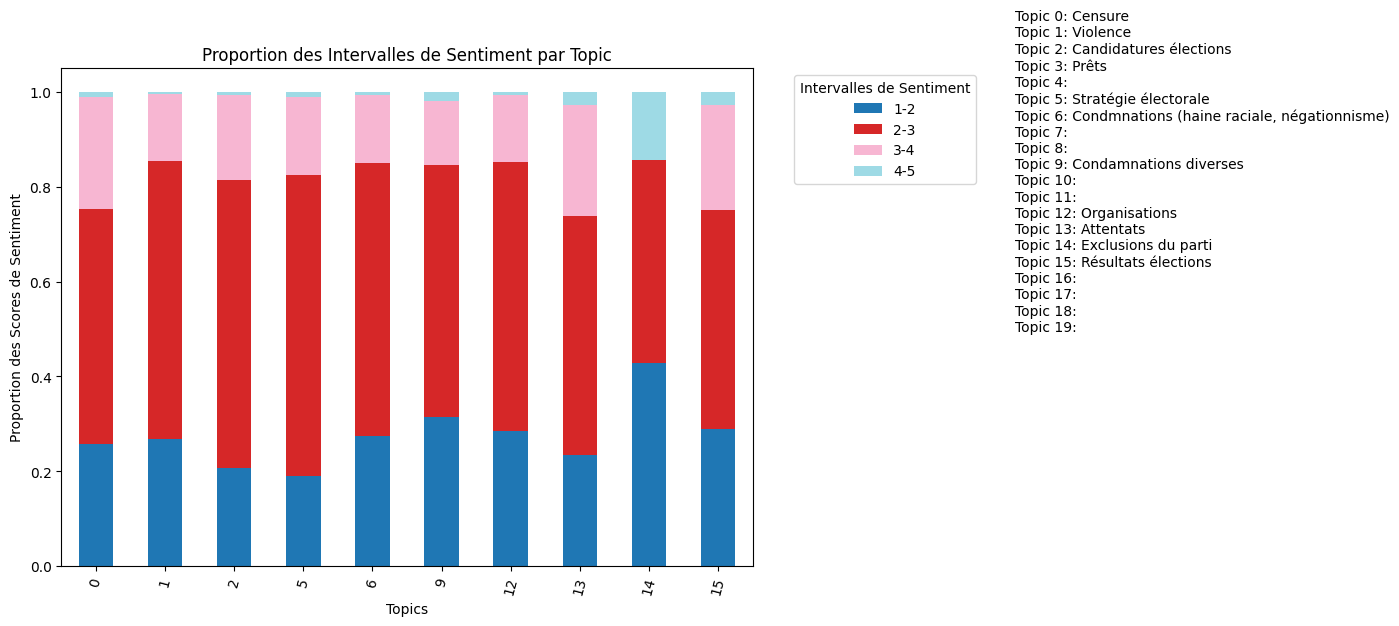

In [ ]:
# Créer des intervalles pour les scores de sentiment
bins = [1, 2, 3, 4, 5]
labels = ['1-2', '2-3', '3-4', '4-5']
df['Sentiment_Interval'] = pd.cut(df['Moyenne_Sentiment'], bins=bins, labels=labels, include_lowest=True)

# Compter les occurrences de chaque intervalle de sentiment par topic
sentiment_count = df.groupby(['Dominant_Topic', 'Sentiment_Interval']).size().unstack(fill_value=0)

# Calculer la proportion de chaque intervalle pour chaque topic
sentiment_proportion = sentiment_count.div(sentiment_count.sum(axis=1), axis=0)

# Tracer un graphique en barres empilées
sentiment_proportion.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
plt.title("Proportion des Intervalles de Sentiment par Topic")
plt.xlabel("Topics")
plt.ylabel("Proportion des Scores de Sentiment")
plt.xticks(rotation=75)
plt.legend(title="Intervalles de Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')
# Afficher la légende des topics à part
legend_labels = [f'Topic {num}: {label}' for num, label in topic_labels.items()]
plt.figtext(1.02, 0.5, "\n".join(legend_labels), horizontalalignment='left', fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
sample = dg.sample(3000)

In [ ]:
sample.to_csv("échantillon_dg.csv", sep = ";", encoding = 'utf-8')

#

# VI- Immigration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import camemBETTER
import matplotlib.pyplot as plt


In [ ]:
df1 = pd.read_csv("admin.csv", sep = ",", encoding = 'utf-8')
df2 = pd.read_csv("admin 2.csv", sep = ",", encoding = 'utf-8')

In [ ]:
df1 = df1[["text", "label"]]
df2 = df2[["text", "label"]]


In [ ]:
df = pd.concat([df1, df2], ignore_index=True)

In [ ]:
df['label'].value_counts()

,count
label,
Immigration,139
Islam,45
Judaïsme,42
Immigration#Judaïsme,13
Immigration#Islam,11
LGBT,9
Islam#Judaïsme,5
Immigration#Islam#Judaïsme#LGBT,1
Immigration#LGBT,1


In [ ]:
df['immigration'] = df['label'].apply(lambda x: 1 if 'immigration' in str(x).lower() else 0)

In [ ]:
model, y_test, X_test = camemBETTER.main(df, "immigration", "text", 2, n = None ,
         balanced = False, sample = False,  weights = [1, 15], epochs = 15 )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation loss: 0.221
Best model saved at epoch 1


Validation loss: 0.082
Best model saved at epoch 2


Validation loss: 0.080
Best model saved at epoch 3


Validation loss: 0.084
No improvement in validation loss for 1 epochs


Validation loss: 0.090
No improvement in validation loss for 2 epochs


Validation loss: 0.083
No improvement in validation loss for 3 epochs
Early stopping on epoch 6
Early stopping triggered after epoch 6


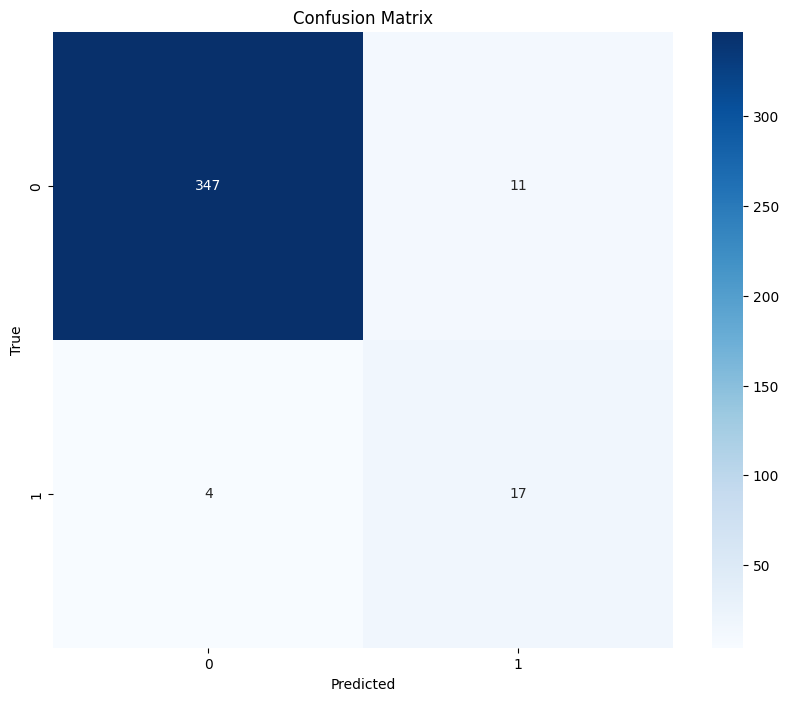

In [ ]:
model.get_prediction(X_test)
model.plot_confusion_matrix(y_test)

In [ ]:
model.score(y_test)

(0.9604221635883905,
 0.9674676198422899,
 0.9604221635883905,
 0.9630537747138854)

In [ ]:
print(X_test)

['Macron – et contre Marine', '" Pour s\'allier au PC, il faut avoir du souffle, surtout au moment où le PC et la CGT ont annoncé qu\'ils vont livrer une bataille sans pitié contre le mariage Renault- Volvo ", a ironisé M. Le Pen.', ' »', "Alors que des élus ont fait savoir qu'ils étaient prêts à déposer des amendements sur le PLFR, le premier ministre les a rappelés à la discipline de parti : « Si la tradition de la VeRépublique, de la majorité parlementaire automatique sous menace du 49-3 n'a jamais fait partie de notre culture, celle de la reparlementarisation à outrance des institutions n'est pas tenable. »", 'Cette question des prénoms est une vieille lune de M.\xa0Zemmour.', 'dans le journal avec«\xa0un haut de couverture et quatre pages intérieures»', '"C\'est un scandale.', 'Autre regard critique, celui de Marine', '"POSITION ÉTHIQUE" Puis Bernard Lapasset, président de la Fédération française de rugby (FFR), et Jo Maso, manager de l\'équipe de France, ont exprimé leur soutien 

In [ ]:
for texte, label in zip(X_test, model.preds):
    if label == 1:
        print(texte)

La ministre de la justice n'est pas la dernière à jouer sur cette corde sensible : accusée par Jacques Kossowski (RPR, Hauts-de-Seine) de « brader » la nationalité française en rétablissant l'acquisition de plein droit à dix-huit ans, Elisabeth Guigou dénonce
Il raconte volontiers que ses parents étaient communistes et cégétistes et sympathisants de SOS Racisme.
"L'ISLAMISME EST LE FILS DE L'IMMIGRATIONNISME"
Il a accusé ce cadre du parti d’extrême droite, également assistant parlementaire de Marine Le Pen et de Sébastien Chenu à l’Assemblée national, d’insultes à caractère raciste et violences légères.
Cela résulte d'une colère, ce n'est pas du racisme », a-t-il assuré.
Au-delà des mégrétistes,
Affirmer que François Hollande a« préféré que des Français meurent plutôt que d’empêcher des migrants de venir en France »est un raccourci caricatural, puisque ce ne sont pas les migrants syriens qui ont perpétré les attentats du 13-Novembre, mais bien des ressortissants européens qui sont entr

In [ ]:
# prompt: enregistrer le modèle

import pickle
# Sauvegarde du modèle dans un fichier
with open("model_immigration.pkl", "wb") as fichier:
    pickle.dump(model, fichier)


In [ ]:
from transformers import CamembertTokenizer, CamembertModel
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')
model = CamembertModel.from_pretrained('camembert-base')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [ ]:
# prompt: ouvrir model_immigration

import pickle

with open("model_immigration.pkl", "rb") as fichier:
    model = pickle.load(fichier)


/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


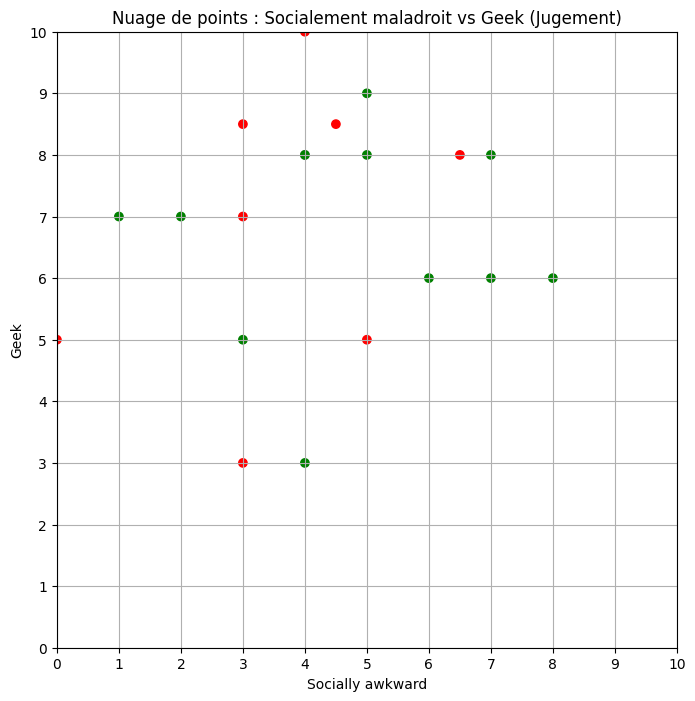

In [ ]:
import matplotlib.pyplot as plt

# Nouvelles données extraites de l'image fournie
socially_awkward = [4.5, 6.5, 4, 7, 2, 0, 8, 7, 3, 5, 3, 4, 6, 5, 3, 1, 4, 3, 5, 4]
geek = [8.5, 8, 10, 6, 7, 5, 6, 8, 7, 8, 8.5, 3, 6, 5, 3, 7, 8, 5, 9, 8]
jugement = ['Bad', 'Bad', 'Bad', 'Nice', 'Nice', 'Bad', 'Nice', 'Nice', 'Bad', 'Nice',
            'Bad', 'Nice', 'Nice', 'Bad', 'Bad', 'Nice', None, 'Nice', 'Nice', 'Nice']

# Définir les couleurs en fonction du jugement
couleurs = ['green' if j == 'Nice' else 'red' if j == 'Bad' else 'gray' for j in jugement]

# Créer le graphique
plt.figure(figsize=(8, 8))

# Tracer les points avec les couleurs associées
plt.scatter(socially_awkward, geek, c=couleurs)

# Définir les limites des axes
plt.xlim(0, 10)  # Limite pour Socially awkward (abscisses)
plt.ylim(0, 10)  # Limite pour Geek (ordonnées)

# Définir les graduations
plt.xticks(range(0, 11, 1))
plt.yticks(range(0, 11, 1))

# Nommer les axes
plt.xlabel('Socially awkward')
plt.ylabel('Geek')

# Ajouter un titre
plt.title('Nuage de points : Socialement maladroit vs Geek (Jugement)')

# Afficher le graphique
plt.grid(True)
plt.show()


In [ ]:
index_list = [2029, 393, 1107, 1370]

In [ ]:
# Filtrer les lignes où la colonne "original_index" est dans index_list
filtered_dg = dg[dg["original_index"].isin(index_list)]


In [ ]:
# Supprimer les lignes avec des NaN dans la colonne 'sentences'
filtered_dg = filtered_dg.dropna(subset=['sentences'])


In [ ]:
test = filtered_dg['sentences'].tolist()

In [ ]:
model.predict(test)

In [ ]:
# Modifier la largeur maximale d'affichage pour les colonnes
pd.set_option('display.max_colwidth', None)
# Créer un DataFrame avec les phrases et leurs prédictions
df_predictions = pd.DataFrame({
    'Sentence': test,
    'Prediction': model.preds
})

# Afficher le DataFrame
print(df_predictions)

In [ ]:
print(df_predictions[df_predictions['Prediction'] == 0]['Sentence'])

0                                                                              Pen a la liberté d’aller où elle veut et Matteo Salvini a la liberté d’inviter qui il veut »à Pontida, a ironisé Guido Crosetto, ministre de la défense et proche de MmeMeloni avec laquelle il a cofondé FDI.
1                                                                      « Nous ne voulons plus qu’on nous impose des politiques que nous n’avons pas choisies », a-t-elle poursuivi, citant notamment« la folle interdiction des moteurs thermiques », autre cheval de bataille de M. Salvini.
3                                                                                                                                                                                                                                                                                       MmeLe
4     Pen a également évoqué devant les milliers de sympathisants de la Ligue sa« déclaration des droits des nations et des peuples »censée pr

In [ ]:
to_predict = dg['sentences'].tolist()

In [ ]:
model.predict(to_predict)

In [ ]:
dg['immigration'] = model.preds

In [ ]:
# prompt: sauvegarder dg

dg.to_csv('/content/drive/MyDrive/Internship/sentences_ed_topics_immigration.csv', index=False)


In [ ]:
# Assurez-vous que la colonne "Date" est au format datetime
dg['Date'] = pd.to_datetime(dg['Date'])

# Extraire l'année et le mois pour regrouper par mois
dg['YearMonth'] = dg['Date'].dt.to_period('M')

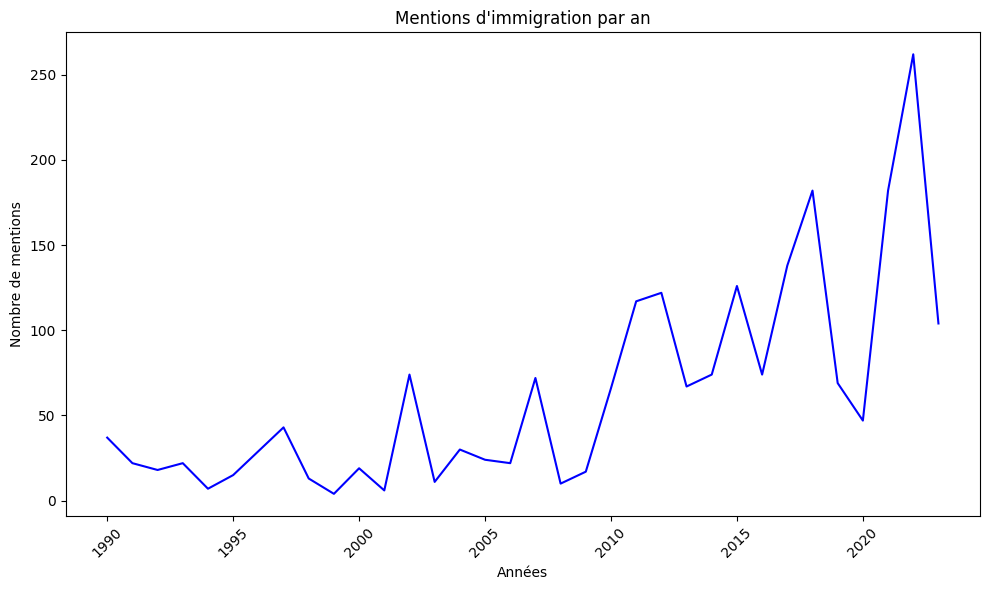

In [ ]:
# Filtrer les lignes où "immigration" est mentionné
immigration_mentions = dg[dg['immigration']==1]

# Compter les mentions d'immigration par mois
mentions_per_month = immigration_mentions.groupby('Year').size()

# Tracer le graphique
plt.figure(figsize=(10, 6))
mentions_per_month.plot(kind='line', color='blue')
plt.title('Mentions d\'immigration par an')
plt.xlabel('Années')
plt.ylabel('Nombre de mentions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
print(total_documents_per_month)

YearMonth
1990-01     23
1990-02     40
1990-03     32
1990-04     30
1990-05     30
          ... 
2023-08    103
2023-09    162
2023-10     65
2023-11    260
2023-12    117
Freq: M, Length: 369, dtype: int64


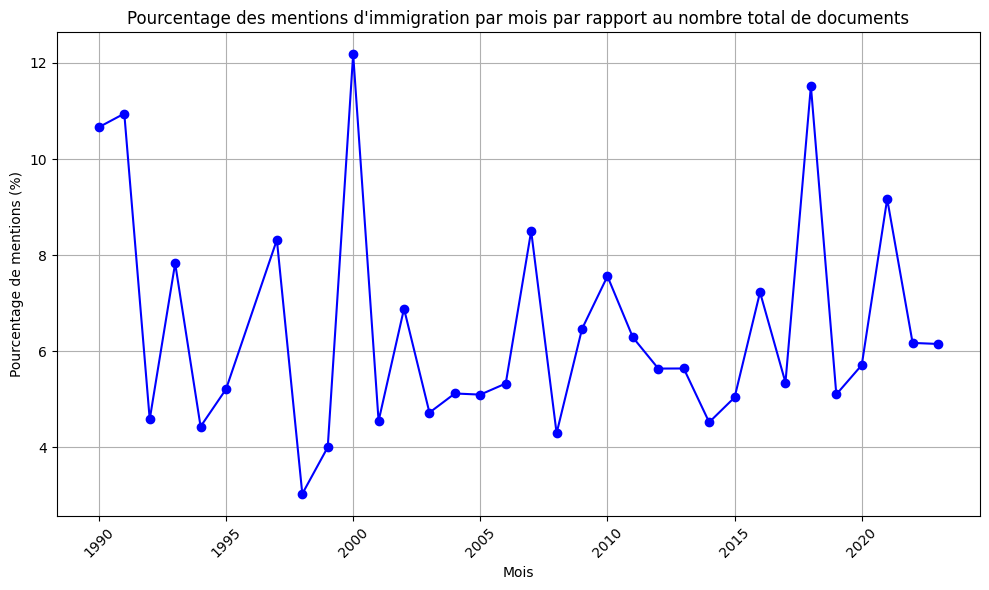

In [ ]:
# Compter le nombre total de documents (tous les documents) par mois
total_documents_per_month = dg.groupby('Year').size()

# Filtrer les lignes où "immigration" est mentionné
immigration_mentions = dg[dg['immigration']==1]

# Compter les mentions d'immigration par mois
mentions_per_month = immigration_mentions.groupby('Year').size()

# Calculer le pourcentage des mentions d'immigration par rapport au nombre total de documents
# Remplir les mois où il n'y a pas de mention avec 0 pour éviter les NaN
mentions_percentage = (mentions_per_month / total_documents_per_month) * 100
mentions_percentage = mentions_percentage.fillna(0)

# Tracer le graphique en pourcentage
plt.figure(figsize=(10, 6))
mentions_percentage.plot(kind='line', marker='o', color='blue')
plt.title('Pourcentage des mentions d\'immigration par mois par rapport au nombre total de documents')
plt.xlabel('Mois')
plt.ylabel('Pourcentage de mentions (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Grouper par 'original_index' et compter les occurrences de 'immigration' == 1
immigration_counts = immigration_mentions.groupby('original_index').size().reset_index(name='Immigration')

# Joindre ce résultat à df en fonction de 'original_index'
df = df.merge(immigration_counts, on='original_index', how='left')

# Remplir les NaN avec 0 pour les 'original_index' qui n'ont pas d'occurrences
df['Immigration'] = df['Immigration'].fillna(0).astype(int)

In [ ]:
# prompt: save df

df.to_csv('/content/drive/MyDrive/Internship/articles_ed_topics_immigration.csv', index=False)


# VII- Statistiques descriptives

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
df.columns

Index(['Full_Text', 'Discours_Concaténé', 'Titre', 'NER_results', 'Date',
       'Lien', 'Type', 'Nuance', 'Parti', 'Presence', 'Dominant_Topic',
       'Topic_Probability', 'Year', 'Topic_Label', 'sentences',
       'original_index', 'Immigration', 'Moyenne_Sentiment', 'Nombre_Phrases'],
      dtype='object')

In [ ]:
# Statistiques descriptives pour les variables numériques
numeric_columns = ['Immigration', 'Moyenne_Sentiment']  # Remplacez 'sentiment_score' par le nom réel de votre colonne
print(df[numeric_columns].describe())


       Immigration  Moyenne_Sentiment
count  2790.000000        2787.000000
mean      0.440143           2.512399
std       1.216521           0.704335
min       0.000000           1.000000
25%       0.000000           2.062500
50%       0.000000           2.500000
75%       0.000000           2.927249
max      16.000000           5.000000


In [ ]:
# Répartition des topics
print(df['Topic_Label'].value_counts())

Topic_Label
Stratégie électorale                           759
Candidatures élections                         584
Condamnations diverses                         333
Violence                                       288
Attentats                                      223
Organisations                                  192
Condmnations (haine raciale, négationnisme)    162
Résultats élections                            153
Censure                                         89
Exclusions du parti                              7
Name: count, dtype: int64


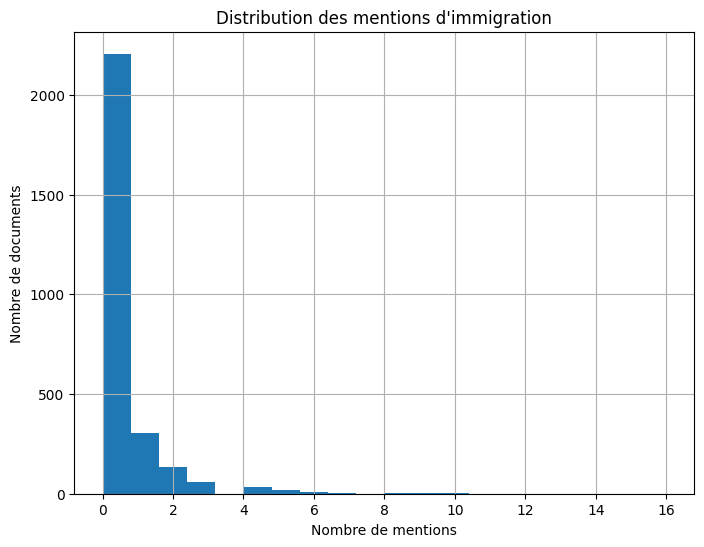

In [ ]:
# Histogramme des mentions d'immigration
plt.figure(figsize=(8, 6))
df['Immigration'].hist(bins=20)
plt.title('Distribution des mentions d\'immigration')
plt.xlabel('Nombre de mentions')
plt.ylabel('Nombre de documents')
plt.show()


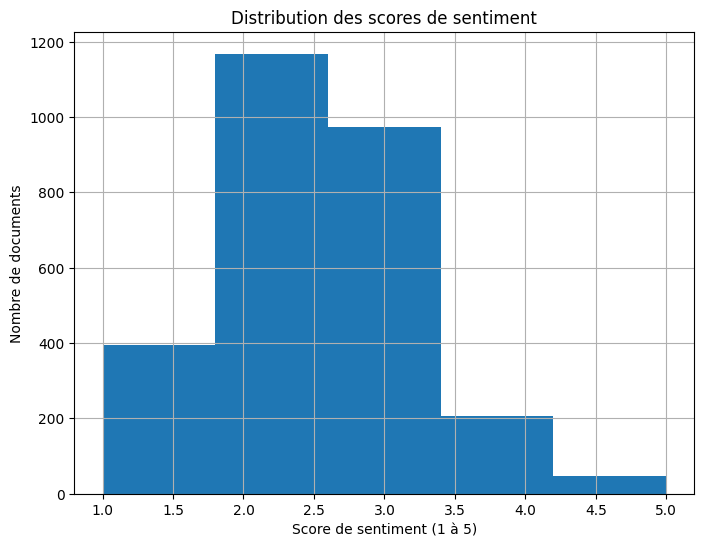

In [ ]:
# Histogramme du score de sentiment
plt.figure(figsize=(8, 6))
df['Moyenne_Sentiment'].hist(bins=5)
plt.title('Distribution des scores de sentiment')
plt.xlabel('Score de sentiment (1 à 5)')
plt.ylabel('Nombre de documents')
plt.show()


In [ ]:
# Matrice de corrélation
print(df[['Immigration', 'Moyenne_Sentiment']].corr())


                   Immigration  Moyenne_Sentiment
Immigration           1.000000           0.011684
Moyenne_Sentiment     0.011684           1.000000


In [ ]:
# Statistiques du score de sentiment par topic
print(df.groupby('Topic_Label')['Moyenne_Sentiment'].describe())

# Statistiques des mentions d'immigration par topic
print(df.groupby('Topic_Label')['Immigration'].describe())


                                             count      mean       std  \
Topic_Label                                                              
Attentats                                    223.0  2.643729  0.760758   
Candidatures élections                       583.0  2.560373  0.683182   
Censure                                       89.0  2.534996  0.719194   
Condamnations diverses                       333.0  2.435826  0.738067   
Condmnations (haine raciale, négationnisme)  162.0  2.392472  0.673066   
Exclusions du parti                            7.0  2.473626  0.828989   
Organisations                                192.0  2.422993  0.659458   
Résultats élections                          151.0  2.599103  0.859234   
Stratégie électorale                         759.0  2.527967  0.658550   
Violence                                     288.0  2.436666  0.703334   

                                                  min       25%       50%  \
Topic_Label                       

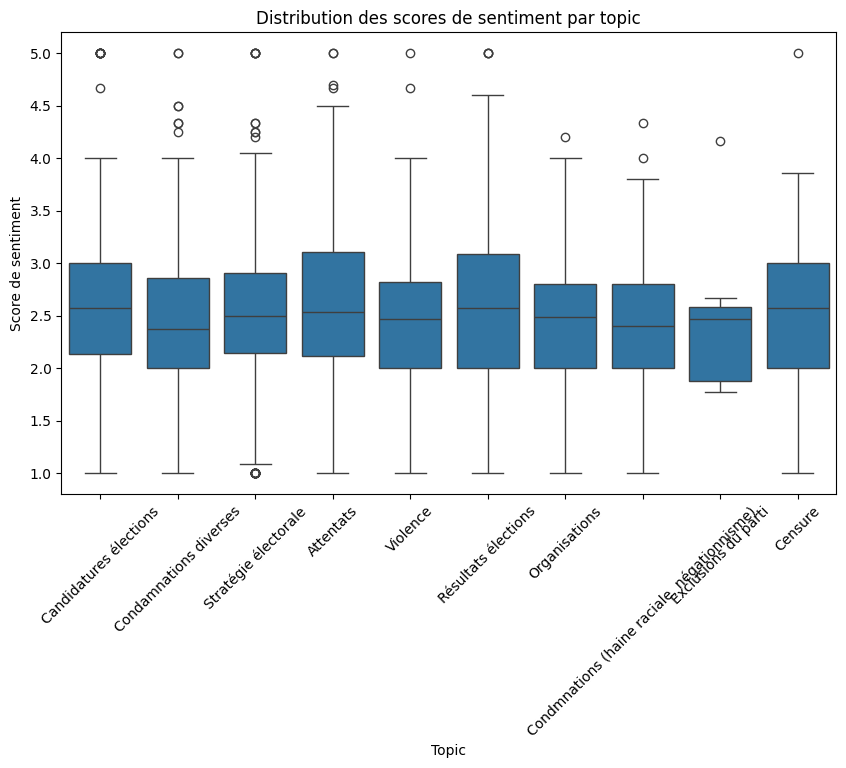

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Topic_Label', y='Moyenne_Sentiment', data=df)
plt.title('Distribution des scores de sentiment par topic')
plt.xlabel('Topic')
plt.ylabel('Score de sentiment')
plt.xticks(rotation=45)
plt.show()

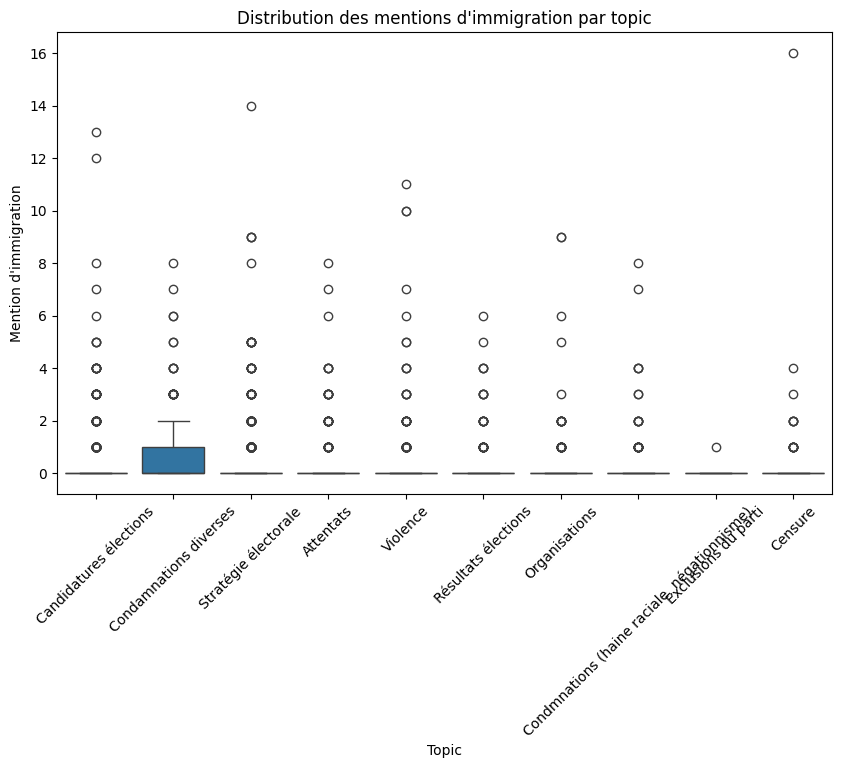

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Topic_Label', y='Immigration', data=df)
plt.title("Distribution des mentions d'immigration par topic")
plt.xlabel('Topic')
plt.ylabel("Mention d'immigration")
plt.xticks(rotation=45)
plt.show()

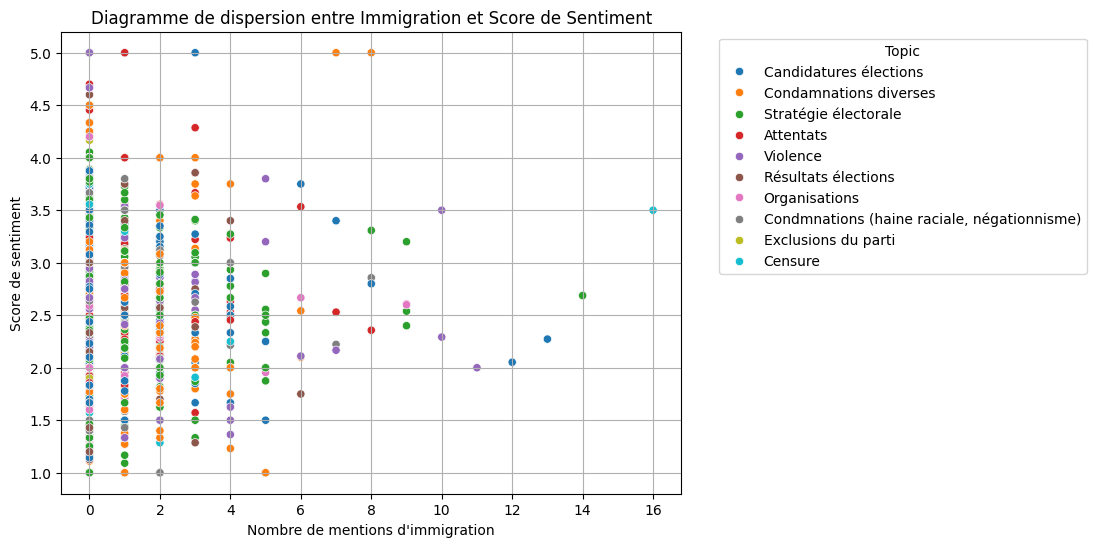

In [ ]:
# Créer le scatter plot avec seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Immigration', y='Moyenne_Sentiment', hue = 'Topic_Label', data=df)
plt.title('Diagramme de dispersion entre Immigration et Score de Sentiment')
plt.xlabel('Nombre de mentions d\'immigration')
plt.ylabel('Score de sentiment')
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
# Création de la variable Moyenne_Sentiment avec des intervalles
df['Sentiment_Catégorie'] = pd.cut(df['Moyenne_Sentiment'],
                                 bins=[1, 2, 3, 4, 5],
                                 labels=['1-2', '2-3', '3-4', '4-5'],
                                 include_lowest=True)

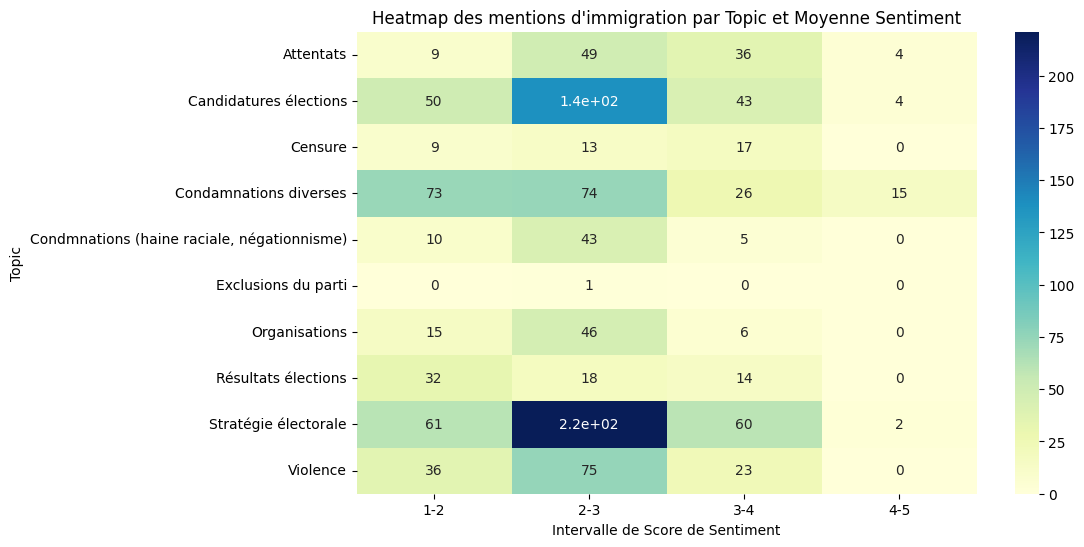

In [ ]:
# Créer un tableau croisé dynamique pour compter les occurrences
pivot_table = df.pivot_table(index='Topic_Label', columns='Sentiment_Catégorie', values='Immigration', aggfunc='sum')

# Créer une heatmap basée sur cette table
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')

plt.title('Heatmap des mentions d\'immigration par Topic et Moyenne Sentiment')
plt.xlabel('Intervalle de Score de Sentiment')
plt.ylabel('Topic')
plt.show()